In [1]:
# Import Library
from pyspark.sql import SparkSession
import itertools
from pyspark.sql.functions import isnan, col, mean, round
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F

In [2]:
# Sesi Spark
spark = SparkSession.builder.appName('First Session').getOrCreate()

## Step 1: Load Dataset 

In [3]:
# Baca dataset tanpa header
df = spark.read.option("header", "false").csv("Rata-rata Pengeluaran Perkapita Seminggu Menurut Kelompok Kacang-Kacangan Per Kabupaten_kota, 2021-2022.csv")

# Ambil header
header = df.take(1)[0]

# Filter baris dengan menggunakan header sebagai referensi
df = df.filter(df['_c0'] != header['_c0'])

# Tampilkan hasil
df.show(5)

+-------------+-------+-------+------+-----+----+-----+-----+-----+------+------+------+-------+-----+-----+-----+----+
|          _c0|    _c1|    _c2|   _c3|  _c4| _c5|  _c6|  _c7|  _c8|   _c9|  _c10|  _c11|   _c12| _c13| _c14| _c15|_c16|
+-------------+-------+-------+------+-----+----+-----+-----+-----+------+------+------+-------+-----+-----+-----+----+
|     Simeulue| 475.28| 582.48|  44.9|18.95|   -|    -|33.89| 56.8| 79.96| 83.12|316.52| 421.32|    -| 2.28|    -|   -|
| Aceh Singkil|2033.93|2189.15|103.43|99.07|2.28|18.45|38.45|14.07| 947.5|1032.3|928.08|1020.29| 0.73| 4.98|13.45|   -|
| Aceh Selatan|1324.44|1016.84|235.14|70.04|   -|    -|45.25|10.67|302.39| 293.1|730.39| 635.83|    -|  5.6|11.27|1.59|
|Aceh Tenggara|1812.45|1864.99| 87.29|30.43|   2|20.39|21.84| 3.72|846.88|908.09| 822.4|  861.9|16.94|36.99|15.11|3.47|
|   Aceh Timur|1329.52|1482.39| 34.91|85.69|   -| 16.5| 39.6|52.32|460.16|504.28|765.32| 800.32|13.48|19.94|16.05|3.34|
+-------------+-------+-------+------+--

In [4]:
num_rows = df.count()
num_columns = len(df.columns)
print("Jumlah baris dalam dataset:", num_rows)
print("Jumlah kolom dalam dataset:", num_columns)

Jumlah baris dalam dataset: 514
Jumlah kolom dalam dataset: 17


In [5]:
tahun_list = ["2021", "2022"]
jenis_list = ["kacang-kacangan", "kacang tanah tanpa kulit", "kacang kedele", "kacang lainnya", "tahu", "tempe", "oncom", "hasil lain dari kacang-kacangan"]

# Ambil dua baris pertama (header dan data)
first_two_rows = df.head(2)
header = first_two_rows[0]

# Rename kolom sesuai dengan yang diinginkan
for index, (tahun, jenis) in enumerate(itertools.product(tahun_list, jenis_list), start=0):
    old_col = f"_c{index}"
    
    if index == 0:
        df = df.withColumnRenamed(old_col, 'Kabupaten/Kota')
    else:
        new_col = f"{tahun}-{jenis}"
        df = df.withColumnRenamed(old_col, new_col)              

df = df.replace("-", "")
df = df.na.drop()

# Tampilkan hasil
df.show(truncate=False)

+---------------+-----------------------------+------------------+-------------------+---------+----------+----------+------------------------------------+--------------------+-----------------------------+------------------+-------------------+---------+----------+----------+------------------------------------+-----+
|Kabupaten/Kota |2021-kacang tanah tanpa kulit|2021-kacang kedele|2021-kacang lainnya|2021-tahu|2021-tempe|2021-oncom|2021-hasil lain dari kacang-kacangan|2022-kacang-kacangan|2022-kacang tanah tanpa kulit|2022-kacang kedele|2022-kacang lainnya|2022-tahu|2022-tempe|2022-oncom|2022-hasil lain dari kacang-kacangan|_c16 |
+---------------+-----------------------------+------------------+-------------------+---------+----------+----------+------------------------------------+--------------------+-----------------------------+------------------+-------------------+---------+----------+----------+------------------------------------+-----+
|Simeulue       |475.28              

## Step 2: Data Validation

In [6]:
# Ganti nama kolom sesuai kebutuhan
new_column_names = ["Kabupaten/Kota", "2021_Kacang-kacangan","2022_Kacang-kacangan","2021_Kacang tanah tanpa kulit",
                    "2022_Kacang tanah tanpa kulit", "2021_Kacang kedele", "2022_Kacang kedele","2021_Kacang lainnya",
                    "2022_Kacang lainnya", "2021_tahu", "2022_tahu", "2021_tempe", "2022_tempe", "2021_oncom", "2022_oncom",
                    "2021_Hasil lain dari kacang-kacangan", "2022_Hasil lain dari kacang-kacangan"]

# Loop untuk mengganti nama kolom
for i in range(len(new_column_names)):
    df = df.withColumnRenamed(df.columns[i], new_column_names[i])

# Tampilkan hasil
df.show(truncate=False)

+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------------------------------------+------------------------------------+
|Kabupaten/Kota |2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|2021_Hasil lain dari kacang-kacangan|2022_Hasil lain dari kacang-kacangan|
+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------------------------------------+------------------------------

In [7]:
columns_to_convert = ["2021_Kacang-kacangan","2022_Kacang-kacangan","2021_Kacang tanah tanpa kulit",
                    "2022_Kacang tanah tanpa kulit", "2021_Kacang kedele", "2022_Kacang kedele","2021_Kacang lainnya",
                    "2022_Kacang lainnya", "2021_tahu", "2022_tahu", "2021_tempe", "2022_tempe", "2021_oncom", "2022_oncom",
                    "2021_Hasil lain dari kacang-kacangan", "2022_Hasil lain dari kacang-kacangan"]

# Mengubah tipe data kolom-kolom menjadi double
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast(DoubleType()))

# Menampilkan tipe data kolom setelah perubahan
df.printSchema()
df.show()

root
 |-- Kabupaten/Kota: string (nullable = true)
 |-- 2021_Kacang-kacangan: double (nullable = true)
 |-- 2022_Kacang-kacangan: double (nullable = true)
 |-- 2021_Kacang tanah tanpa kulit: double (nullable = true)
 |-- 2022_Kacang tanah tanpa kulit: double (nullable = true)
 |-- 2021_Kacang kedele: double (nullable = true)
 |-- 2022_Kacang kedele: double (nullable = true)
 |-- 2021_Kacang lainnya: double (nullable = true)
 |-- 2022_Kacang lainnya: double (nullable = true)
 |-- 2021_tahu: double (nullable = true)
 |-- 2022_tahu: double (nullable = true)
 |-- 2021_tempe: double (nullable = true)
 |-- 2022_tempe: double (nullable = true)
 |-- 2021_oncom: double (nullable = true)
 |-- 2022_oncom: double (nullable = true)
 |-- 2021_Hasil lain dari kacang-kacangan: double (nullable = true)
 |-- 2022_Hasil lain dari kacang-kacangan: double (nullable = true)

+---------------+--------------------+--------------------+-----------------------------+-----------------------------+---------------

In [8]:
# Menghitung nilai rata-rata untuk mengisi nilai NULL
mean_values = df.agg(*[round(mean(col(c)), 2).alias(c) for c in df.columns if c != "Kabupaten/Kota"])

# Mengisi nilai NULL dengan nilai rata-rata
cleaned_df = df.na.fill(mean_values.first().asDict())

# Menampilkan DataFrame setelah pengisian nilai NULL
cleaned_df.show(truncate=False)

+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------------------------------------+------------------------------------+
|Kabupaten/Kota |2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|2021_Hasil lain dari kacang-kacangan|2022_Hasil lain dari kacang-kacangan|
+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------------------------------------+------------------------------

In [9]:
columns_to_select = cleaned_df.select("Kabupaten/Kota", "2021_Kacang-kacangan","2022_Kacang-kacangan","2021_Kacang tanah tanpa kulit",
                    "2022_Kacang tanah tanpa kulit", "2021_Kacang kedele", "2022_Kacang kedele","2021_Kacang lainnya",
                    "2022_Kacang lainnya", "2021_tahu", "2022_tahu", "2021_tempe", "2022_tempe", "2021_oncom", "2022_oncom")
columns_to_select.show()

+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
| Kabupaten/Kota|2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|
+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
|       Simeulue|              475.28|              582.48|                         44.9|                        18.95|             14.02|             15.37|              33.89|               56.8|    79.96|    83.

In [10]:
# import os

# # Tentukan path direktori yang ingin Anda gunakan
# direktori_path = "path/to/save"

# # Periksa apakah direktori sudah ada atau belum
# if not os.path.exists(direktori_path):
#     # Jika belum ada, buat direktori
#     os.makedirs(direktori_path)

# # Sekarang Anda bisa menyimpan file ke dalam direktori yang sudah dibuat
# excel_file_path = os.path.join(direktori_path, "after_handling.xlsx")

# # Simpan Pandas DataFrame ke file Excel
# pandas_df.to_excel(excel_file_path, index=False)

# # Tampilkan pesan bahwa penyimpanan berhasil
# print(f"DataFrame berhasil disimpan dalam file Excel di: {excel_file_path}")


## Step 3: Find the optimal number of clusters using the silhouette method.

In [11]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=[
    '2021_Kacang-kacangan', '2022_Kacang-kacangan', '2021_Kacang tanah tanpa kulit',
    '2022_Kacang tanah tanpa kulit', '2021_Kacang kedele', '2022_Kacang kedele', 
    '2021_Kacang lainnya', '2022_Kacang lainnya', '2021_tahu', '2022_tahu', '2021_tempe', 
    '2022_tempe', '2021_oncom', '2022_oncom'],outputCol = 'features')

assembled_data=assemble.transform(cleaned_df)

In [12]:
assembled_data.show()

+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------------------------------------+------------------------------------+--------------------+
| Kabupaten/Kota|2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|2021_Hasil lain dari kacang-kacangan|2022_Hasil lain dari kacang-kacangan|            features|
+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+-------------------------

In [13]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')

for K in range(2,11):
    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)
    BKMeans_fit=BKMeans_.fit(assembled_data)
    BKMeans_transform=BKMeans_fit.transform(assembled_data) 
    evaluation_score=evaluator.evaluate(BKMeans_transform)
    silhouette_scores.append(evaluation_score)

In [14]:
silhouette_scores

[0.664265816293618,
 0.5019717189662483,
 0.5314764027314728,
 0.3531774196306854,
 0.28698530263239713,
 0.2839206207102289,
 0.3668826824036841,
 0.3001896457796477,
 0.24900135406021373]

Text(0, 0.5, 'Silhouette Score')

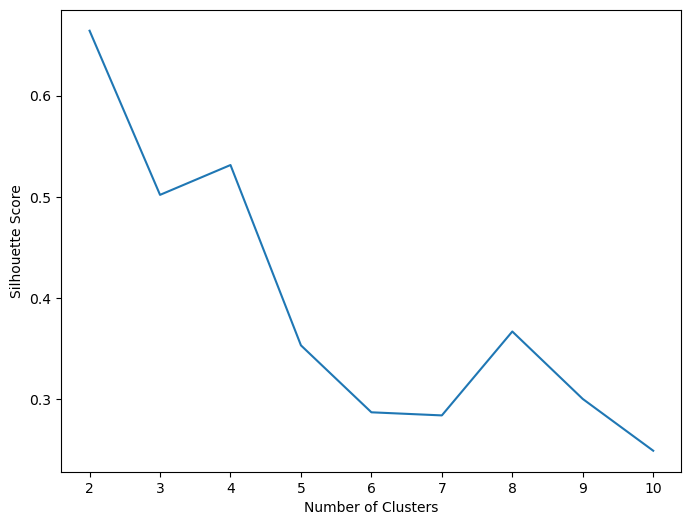

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

## Step 4: Build the BisectingKMeans/Hierarchical Clustering model

In [16]:
BKMeans_=BisectingKMeans(featuresCol='features', k=6) 
BKMeans_Model=BKMeans_.fit(assembled_data)
BKMeans_transform=BKMeans_Model.transform(assembled_data)

In [17]:
BKMeans_transform.show(5)

+--------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------------------------------------+------------------------------------+--------------------+----------+
|Kabupaten/Kota|2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|2021_Hasil lain dari kacang-kacangan|2022_Hasil lain dari kacang-kacangan|            features|prediction|
+--------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------

In [18]:
data = BKMeans_transform.select('features')
data.show(11)

+--------------------+
|            features|
+--------------------+
|[475.28,582.48,44...|
|[2033.93,2189.15,...|
|[1324.44,1016.84,...|
|[1812.45,1864.99,...|
|[1329.52,1482.39,...|
|[2953.51,2982.12,...|
|[2187.72,2194.79,...|
|[1776.45,1774.67,...|
|[1470.29,1471.89,...|
|[2008.42,1708.89,...|
|[1228.4,1556.62,6...|
+--------------------+
only showing top 11 rows



In [19]:
datshow = data.toPandas()
print(datshow.head())

                                            features
0  [475.28, 582.48, 44.9, 18.95, 14.02, 15.37, 33...
1  [2033.93, 2189.15, 103.43, 99.07, 2.28, 18.45,...
2  [1324.44, 1016.84, 235.14, 70.04, 14.02, 15.37...
3  [1812.45, 1864.99, 87.29, 30.43, 2.0, 20.39, 2...
4  [1329.52, 1482.39, 34.91, 85.69, 14.02, 16.5, ...


## Step 5: Visualize Hierarchical Clustering using the PCA

In [20]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

pca_transformed.show(4)

+--------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+------------------------------------+------------------------------------+--------------------+--------------------+
|Kabupaten/Kota|2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|2021_Hasil lain dari kacang-kacangan|2022_Hasil lain dari kacang-kacangan|            features|                 pca|
+--------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+--------

In [21]:
# Menggunakan select untuk memilih kolom 'pca'
X_pca = pca_transformed.select("pca")

# Menampilkan hasil
X_pca.show(5)

+--------------------+
|                 pca|
+--------------------+
|[-883.90193355327...|
|[-3572.4030427258...|
|[-1908.8447645937...|
|[-3107.7009326274...|
|[-2366.4696155577...|
+--------------------+
only showing top 5 rows



In [22]:
import pandas as pd
X_pca_pd = X_pca.toPandas()
print(X_pca_pd.head(514))

                                           pca
0     [-883.9019335532776, -4.090849141278189]
1     [-3572.4030427258976, 156.3869428602995]
2     [-1908.8447645937076, 287.6619978510805]
3     [-3107.700932627474, 218.78862156085737]
4     [-2366.4696155577267, 69.30341559097445]
..                                         ...
509   [-490.2099665697026, 17.103862829649998]
510   [-2119.143475660604, -762.5228317851236]
511  [-1115.6895673907425, -73.13545285946715]
512   [-1428.2929186734902, 351.6555452141348]
513   [-6187.315758381206, -99.18316611543626]

[514 rows x 1 columns]


In [23]:
!pip install scipy

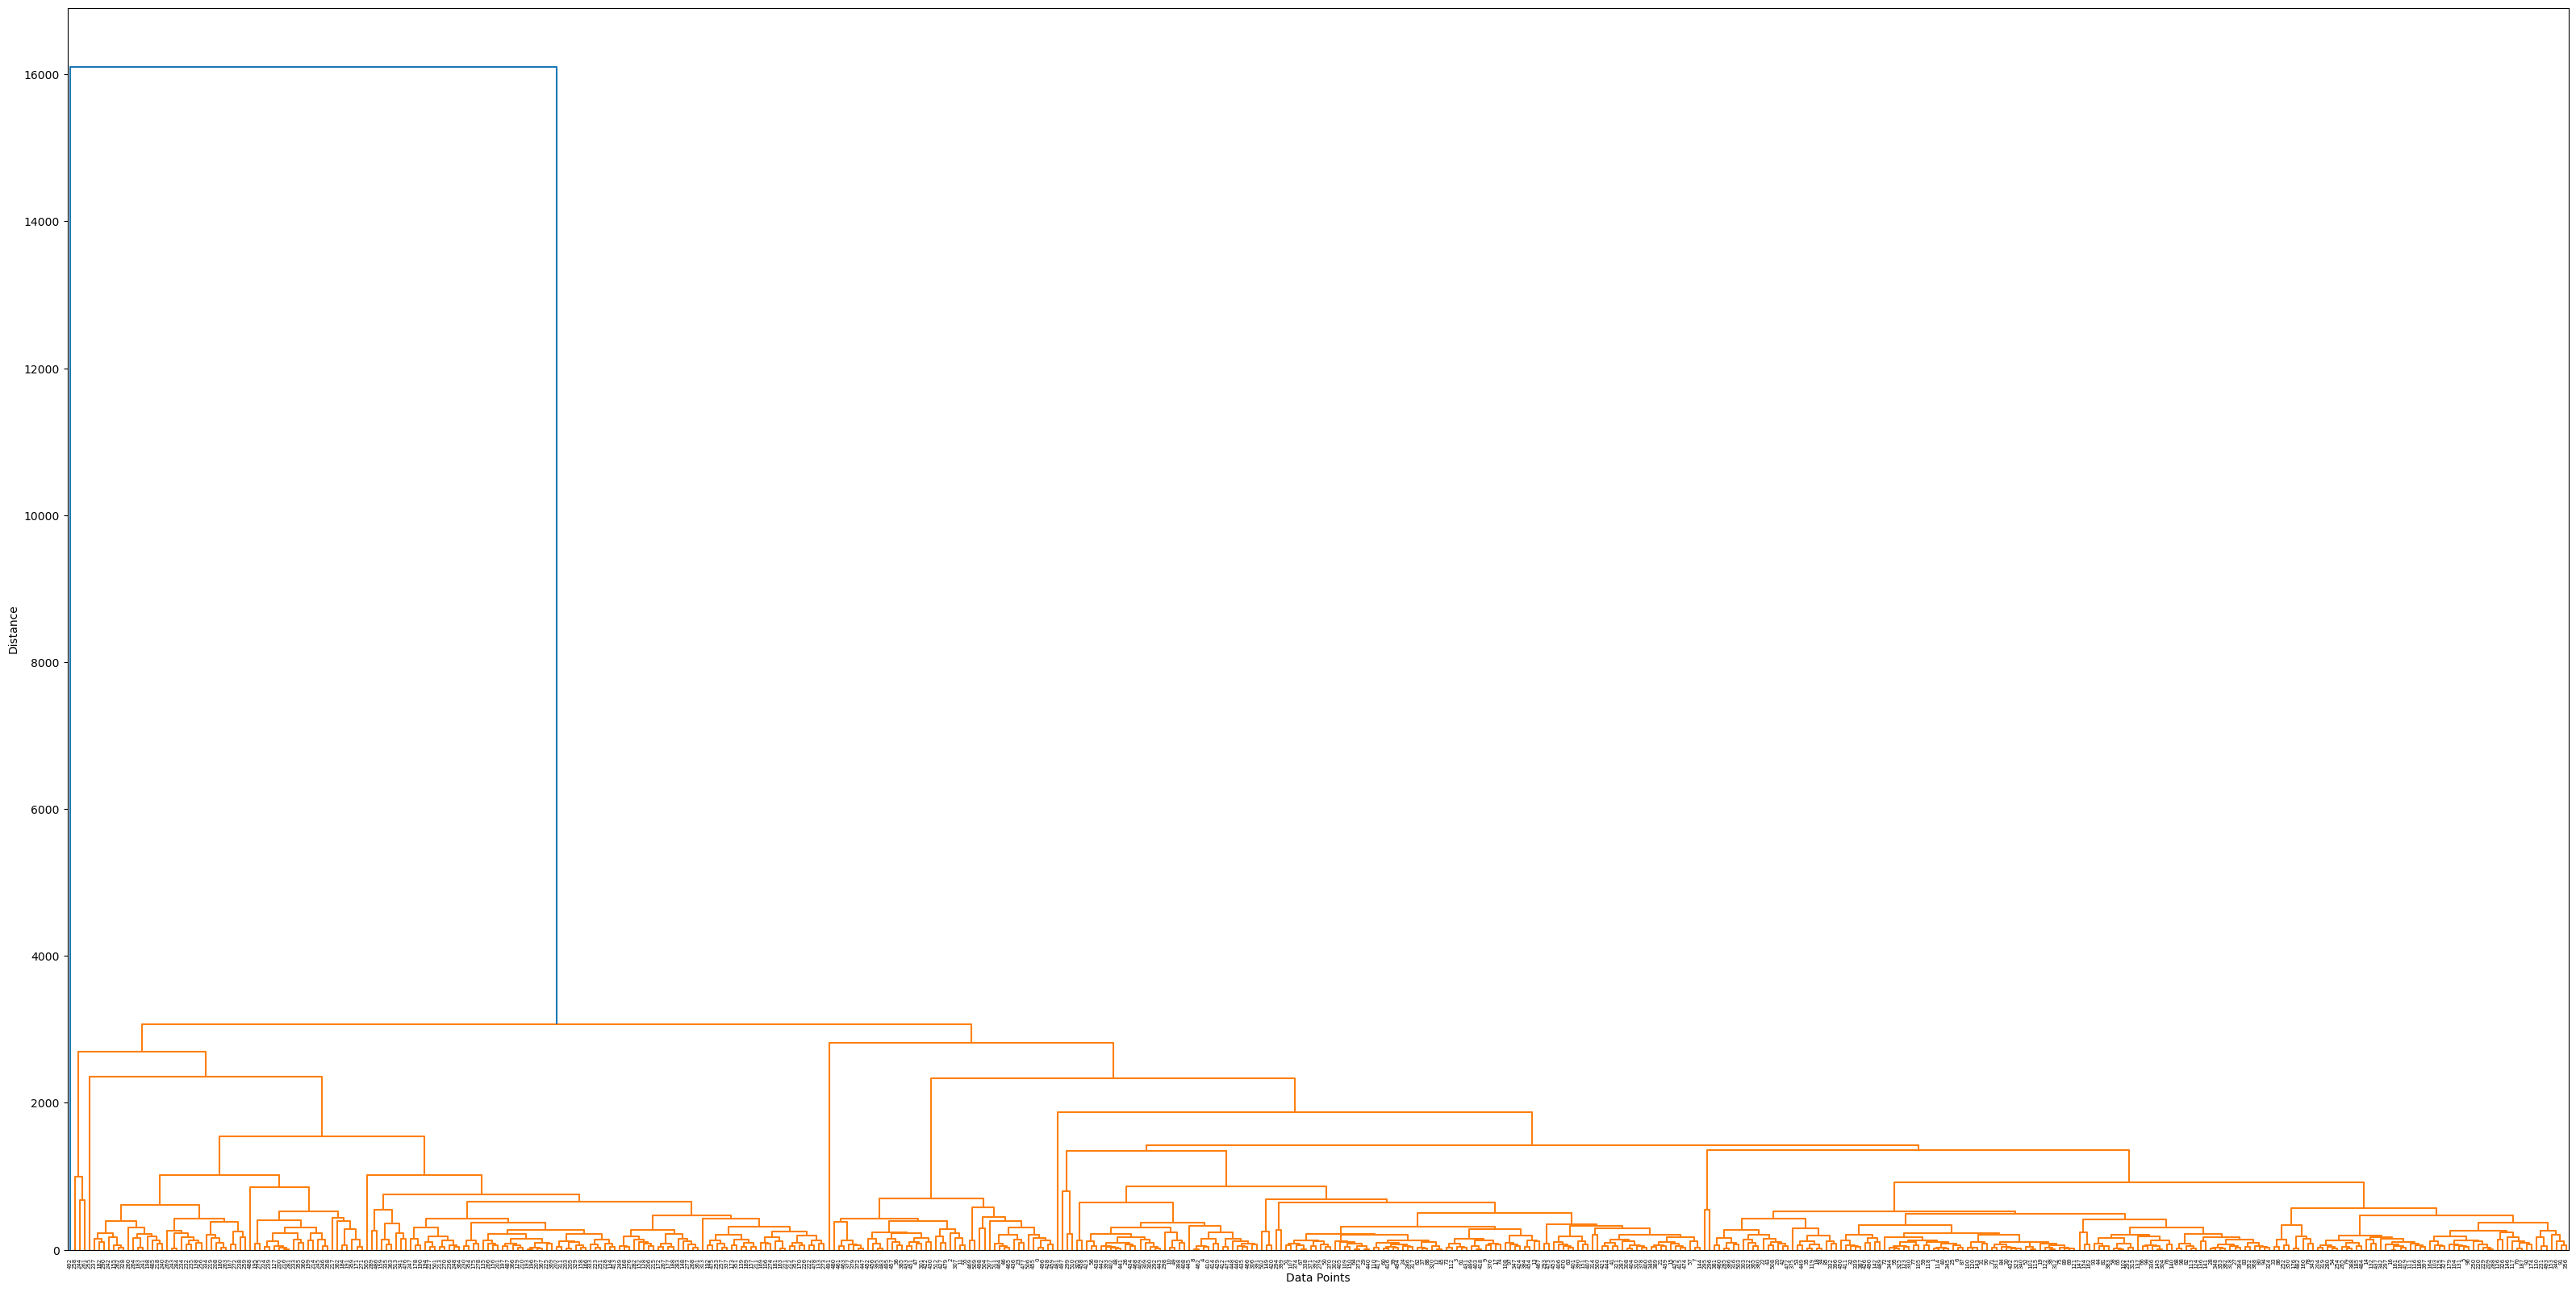

In [24]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Mengambil kolom features dari hasil PCA
features_array = np.array(X_pca_pd['pca'].tolist())

# featutres_array itu pca yang sudah dalam bentuk array
# Menghitung matriks linkage
linkage_matrix = linkage(features_array, 'average')

# Set the size of the plot
plt.figure(figsize=(40, 20))

# Membuat dendrogram
dendrogram(linkage_matrix)

# Menambahkan label pada sumbu x
plt.xlabel('Data Points')
plt.ylabel('Distance')

# Menampilkan dendrogram
plt.show()

In [1]:
# # Calculate linkage matrix
# linked = linkage(features_array, method='average')

# # Plot dendrogram
# plt.figure(figsize=(10, 6),dpi=200)
# dendrogram(linked, orientation='top', distance_sort='descending', truncate_mode='level', p=2, show_leaf_counts=True)
# plt.title('Dendrogram')
# plt.xlabel('Samples')
# plt.ylabel('Distance')
# plt.show()

In [26]:
# Mengambil kolom hasil klastering dari Bisecting K-Means
cluster_assignment = np.array(BKMeans_transform.select('prediction').collect())

# print(cluster_assignment)

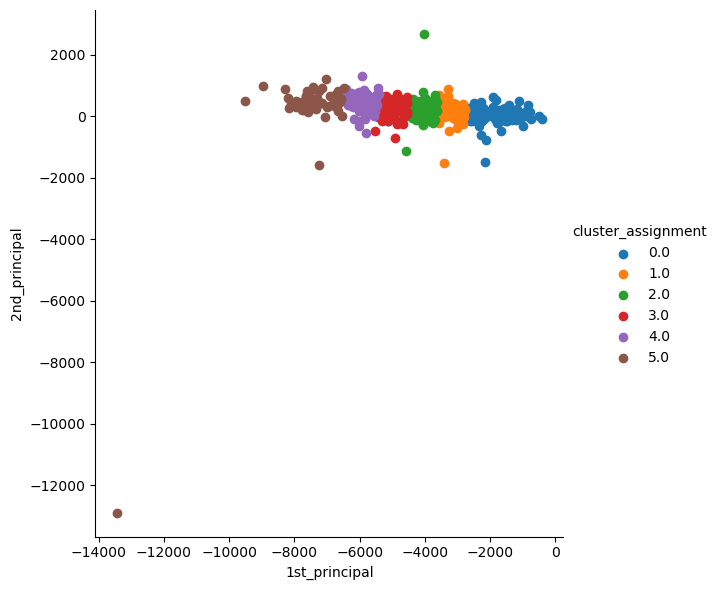

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((features_array,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', \
                                                             '2nd_principal' ).add_legend()
plt.show()

In [28]:
# Membuat DataFrame hasil PCA dan klastering
pca_df = pd.DataFrame(data=pca_data, columns=["1st_principal", "2nd_principal", "cluster_assignment"])

# Membuat dictionary untuk menyimpan anggota klaster
cluster_members = {}

# Iterasi melalui setiap klaster
for cluster in pca_df['cluster_assignment'].unique():
    # Mendapatkan indeks data poin yang termasuk dalam klaster tersebut
    cluster_indices = pca_df[pca_df['cluster_assignment'] == cluster].index.tolist()
    
    # Menambahkan informasi klaster ke dictionary
    cluster_members[cluster] = cluster_indices

# # Menampilkan anggota klaster
# for cluster, members in cluster_members.items():
#     print(f"Cluster {cluster} Members: {members}");

In [29]:
# Mengurutkan klaster berdasarkan jumlah anggota
sorted_clusters = sorted(cluster_members.items(), key=lambda x: len(x[1]), reverse=True)

# Menampilkan anggota klaster secara terurut
for cluster, members in sorted_clusters:
    print(f"Cluster {cluster} Members ({len(members)} anggota): {members}")

Cluster 2.0 Members (107 anggota): [18, 19, 20, 22, 25, 27, 28, 30, 31, 32, 34, 35, 38, 42, 43, 44, 52, 53, 54, 58, 65, 66, 68, 69, 71, 75, 76, 79, 80, 81, 82, 83, 84, 85, 87, 89, 90, 93, 94, 98, 99, 100, 101, 102, 113, 115, 119, 120, 121, 122, 124, 136, 137, 140, 141, 142, 143, 145, 147, 154, 162, 185, 204, 254, 265, 280, 285, 291, 295, 297, 304, 312, 315, 316, 318, 319, 323, 324, 331, 332, 336, 339, 340, 348, 352, 353, 365, 368, 375, 381, 382, 383, 386, 388, 394, 396, 426, 432, 437, 449, 460, 472, 484, 490, 491, 503, 508]
Cluster 1.0 Members (101 anggota): [1, 3, 6, 7, 9, 12, 13, 17, 21, 24, 29, 37, 39, 40, 45, 50, 51, 57, 59, 60, 61, 62, 63, 64, 67, 72, 73, 74, 77, 88, 95, 97, 105, 107, 108, 109, 110, 112, 114, 118, 123, 144, 149, 150, 151, 279, 286, 294, 302, 303, 314, 317, 320, 322, 325, 330, 338, 344, 345, 347, 349, 370, 371, 373, 374, 376, 380, 384, 387, 389, 390, 392, 399, 401, 403, 405, 406, 407, 411, 416, 417, 418, 420, 421, 424, 425, 431, 439, 440, 444, 450, 453, 454, 467, 4

In [30]:
# Mengurutkan klaster berdasarkan jumlah anggota (terbesar ke terkecil)
sorted_clusters = sorted(cluster_members.items(), key=lambda x: len(x[1]), reverse=True)

# Membuat DataFrame baru untuk menyimpan hasil klaster yang sudah diurutkan
sorted_cluster_df = pd.DataFrame(columns=["Kabupaten/Kota", "Cluster Assignment"])

# Menggabungkan hasil klaster yang sudah diurutkan dengan DataFrame asli
for cluster, members in sorted_clusters:
    cluster_df = pd.DataFrame({"Kabupaten/Kota": members, "Cluster Assignment": [cluster] * len(members)})
    sorted_cluster_df = pd.concat([sorted_cluster_df, cluster_df])

# Menampilkan DataFrame hasil klaster yang sudah diurutkan
print(sorted_cluster_df)

   Kabupaten/Kota  Cluster Assignment
0              18                 2.0
1              19                 2.0
2              20                 2.0
3              22                 2.0
4              25                 2.0
..            ...                 ...
52            359                 5.0
53            362                 5.0
54            485                 5.0
55            488                 5.0
56            492                 5.0

[514 rows x 2 columns]


In [31]:
wilayah = BKMeans_transform.select("Kabupaten/Kota").collect()
list_wilayah = [row[0] for row in wilayah]
print(list_wilayah)

['Simeulue', 'Aceh Singkil', 'Aceh Selatan', 'Aceh Tenggara', 'Aceh Timur', 'Aceh Tengah', 'Aceh Barat', 'Aceh Besar', 'Pidie', 'Bireuen', 'Aceh Utara', 'Aceh Barat Daya', 'Gayo Lues', 'Aceh Tamiang', 'Nagan Raya', 'Aceh Jaya', 'Bener Meriah', 'Pidie Jaya', 'Kota Banda Aceh', 'Kota Sabang', 'Kota Langsa', 'Kota Lhokseumawe', 'Kota Subulussalam', 'Nias', 'Mandailing Natal', 'Tapanuli Selatan', 'Tapanuli Tengah', 'Tapanuli Utara', 'Toba Samosir', 'Labuhan Batu', 'Asahan', 'Simalungun', 'Dairi', 'Karo', 'Deli Serdang', 'Langkat', 'Nias Selatan', 'Humbang Hasundutan', 'Pakpak Bharat', 'Samosir', 'Serdang Bedagai', 'Batu Bara', 'Padang Lawas Utara', 'Padang Lawas', 'Labuhan Batu Selatan', 'Labuhan Batu Utara', 'Nias Utara', 'Nias Barat', 'Kota Sibolga', 'Kota Tanjung Balai', 'Kota Pematang Siantar', 'Kota Tebing Tinggi', 'Kota Medan', 'Kota Binjai', 'Kota Padangsidimpuan', 'Kota Gunungsitoli', 'Kepulauan Mentawai', 'Pesisir Selatan', 'Solok', 'Sijunjung', 'Tanah Datar', 'Padang Pariaman', '

In [32]:
# Membuat DataFrame baru untuk menyimpan hasil klaster yang sudah diurutkan
sorted_cluster_df = pd.DataFrame(columns=["Kabupaten/Kota", "Cluster Assignment"])

# Menggabungkan hasil klaster yang sudah diurutkan dengan DataFrame asli
for cluster, members in sorted_clusters:
    cluster_df = pd.DataFrame({"Kabupaten/Kota": members, "Cluster Assignment": [cluster] * len(members)})
    sorted_cluster_df = pd.concat([sorted_cluster_df, cluster_df])

# Menggantikan indeks dengan nama Kabupaten/Kota
sorted_cluster_df['Kabupaten/Kota'] = sorted_cluster_df['Kabupaten/Kota'].replace(dict(enumerate(list_wilayah)))

# Menampilkan DataFrame hasil klaster yang sudah diurutkan dengan nama Kabupaten/Kota
print(sorted_cluster_df)

       Kabupaten/Kota  Cluster Assignment
0     Kota Banda Aceh                 2.0
1         Kota Sabang                 2.0
2         Kota Langsa                 2.0
3   Kota Subulussalam                 2.0
4    Tapanuli Selatan                 2.0
..                ...                 ...
52              Berau                 5.0
53    Kota Balikpapan                 5.0
54            Merauke                 5.0
55             Nabire                 5.0
56        Puncak Jaya                 5.0

[514 rows x 2 columns]


In [2]:
# # Menentukan jumlah maksimal baris yang akan ditampilkan dalam satu bagian
# max_rows_per_chunk = 10

# # Membagi DataFrame menjadi beberapa bagian
# num_chunks = len(sorted_cluster_df) // max_rows_per_chunk + 1

# # Menampilkan setiap bagian
# for i in range(num_chunks):
#     start_idx = i * max_rows_per_chunk
#     end_idx = (i + 1) * max_rows_per_chunk
#     chunk_df = sorted_cluster_df.iloc[start_idx:end_idx]
    
#     print(f"Chunk {i + 1}/{num_chunks}")
#     print(chunk_df)
#     print("\n" + "=" * 50 + "\n")  # Garis pemisah antar bagian


In [3]:
# # Menentukan jumlah maksimal baris yang akan ditampilkan dalam satu bagian
# max_rows_per_chunk = 10

# # Membagi DataFrame menjadi beberapa bagian
# num_chunks = len(sorted_cluster_df) // max_rows_per_chunk + 1

# # Menampilkan setiap bagian
# for i in range(num_chunks):
#     start_idx = i * max_rows_per_chunk
#     end_idx = (i + 1) * max_rows_per_chunk
#     chunk_df = sorted_cluster_df.iloc[start_idx:end_idx]
    
#     # Menampilkan Kabupaten/Kota sebagai list
#     kabupaten_kota_list = chunk_df['Kabupaten/Kota'].tolist()
    
#     print(f"Chunk {i + 1}/{num_chunks}")
#     print("Kabupaten/Kota List:")
#     print(kabupaten_kota_list)
#     print("\n" + "=" * 50 + "\n")  # Garis pemisah antar bagian


# Data Analysis Insights

### 1. Analisa Dengan Dataset

In [35]:
select_to_analysis = cleaned_df.select("Kabupaten/Kota", "2021_Kacang-kacangan","2022_Kacang-kacangan","2021_Kacang tanah tanpa kulit",
                    "2022_Kacang tanah tanpa kulit", "2021_Kacang kedele", "2022_Kacang kedele","2021_Kacang lainnya",
                    "2022_Kacang lainnya", "2021_tahu", "2022_tahu", "2021_tempe", "2022_tempe", "2021_oncom", "2022_oncom")
select_to_analysis.show(3)

+--------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
|Kabupaten/Kota|2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|
+--------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
|      Simeulue|              475.28|              582.48|                         44.9|                        18.95|             14.02|             15.37|              33.89|               56.8|    79.96|    83.12| 

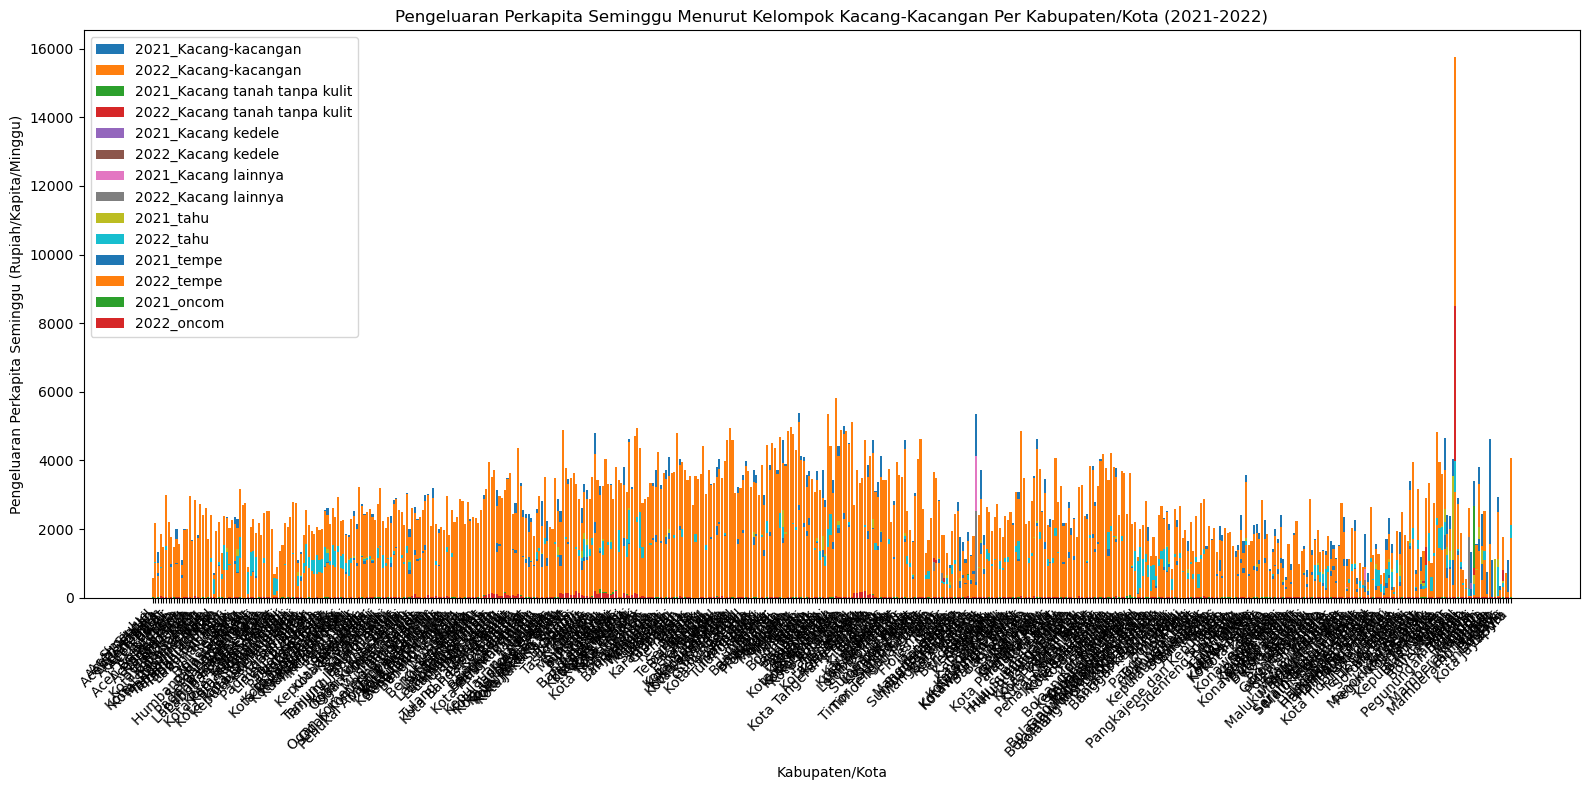

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Ambil data yang diperlukan untuk visualisasi
visualization_data = select_to_analysis.toPandas()

# Set up plot
plt.figure(figsize=(16, 8))

# Loop untuk setiap kolom kecuali Kabupaten/Kota
for col in visualization_data.columns[1:]:
    plt.bar(visualization_data["Kabupaten/Kota"], visualization_data[col], label=col)

# Tambahkan label dan judul
plt.xlabel("Kabupaten/Kota")
plt.ylabel("Pengeluaran Perkapita Seminggu (Rupiah/Kapita/Minggu)")
plt.title("Pengeluaran Perkapita Seminggu Menurut Kelompok Kacang-Kacangan Per Kabupaten/Kota (2021-2022)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Tampilkan plot
plt.show()

In [37]:
from pyspark.sql.functions import isnan, col

kabupaten_timur_list = ["Merauke", "Jayawijaya", "Jayapura", "Nabire", "Kepulauan Yapen", 
              "Biak Numfor", "Paniai", "Puncak Jaya", "Mimika", "Boven Digoel", 
              "Mappi", "Asmat", "Yahukimo", "Pegunungan Bintang", "Tolikara", 
              "Sarmi", "Keerom", "Waropen", "Supiori", "Mamberamo Raya", 
              "Nduga", "Lanny Jaya", "Mamberamo Tengah", "Yalimo", "Puncak", 
              "Dogiyai", "Intan Jaya", "Deiyai", "Kota Jayapura"]
# Filter DataFrame untuk hanya menyertakan kabupaten/kota yang terdaftar
selected_provinsi_papua = select_to_analysis.filter(col("Kabupaten/Kota").isin(kabupaten_timur_list))

# Tampilkan DataFrame yang telah difilter
selected_provinsi_papua.show(truncate=False)

+------------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
|Kabupaten/Kota    |2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|
+------------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
|Merauke           |4416.12             |4819.56             |99.77                        |339.26                       |14.02             |3.34              |22.56              |46.64              |2255.

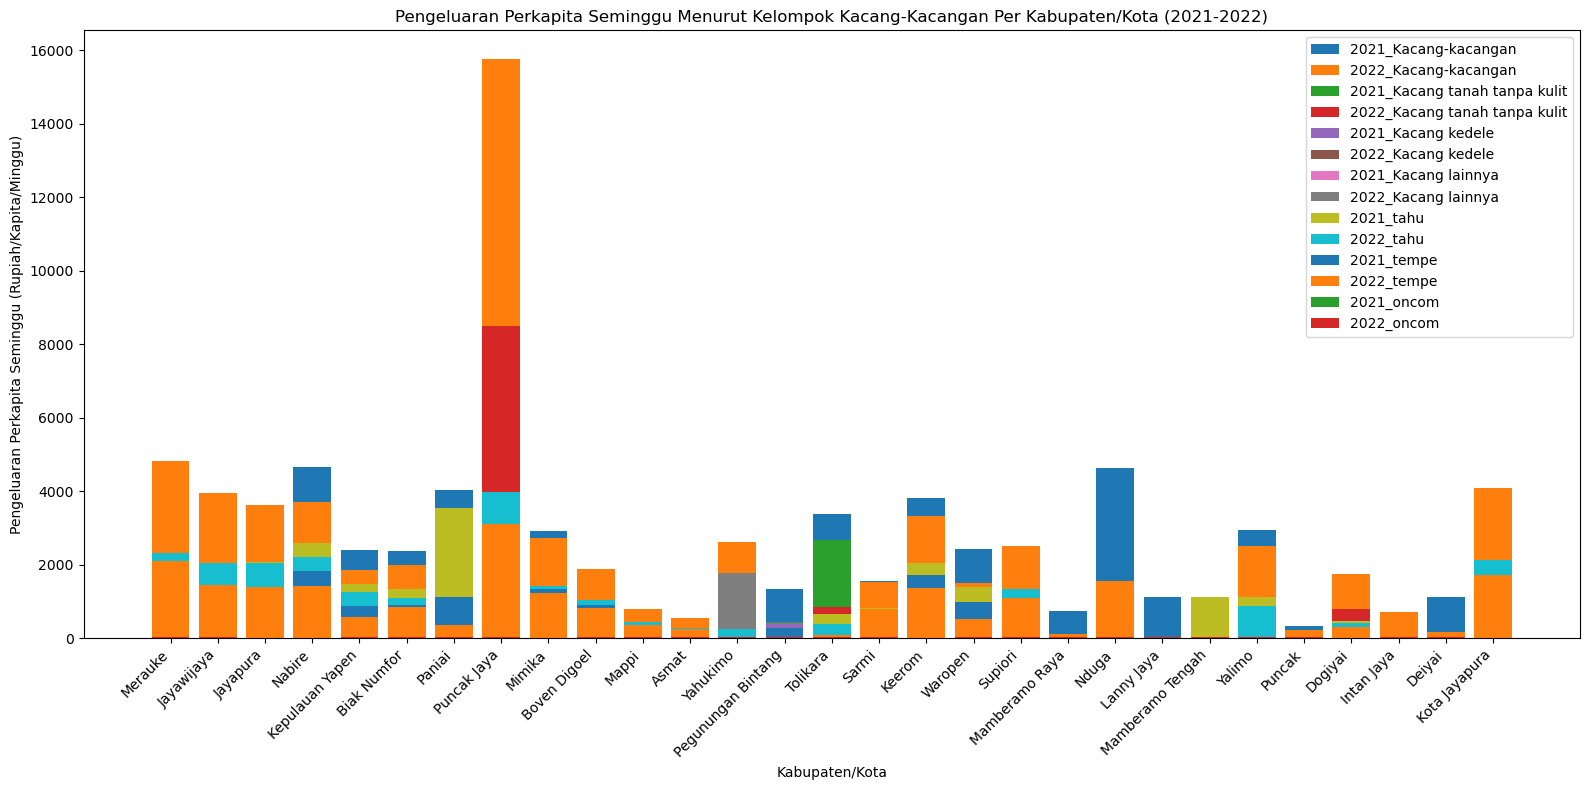

In [38]:
# Ambil data yang diperlukan untuk visualisasi
visualization_data = selected_provinsi_papua.toPandas()

# Set up plot
plt.figure(figsize=(16, 8))

# Loop untuk setiap kolom kecuali Kabupaten/Kota
for col in visualization_data.columns[1:]:
    plt.bar(visualization_data["Kabupaten/Kota"], visualization_data[col], label=col)

# Tambahkan label dan judul
plt.xlabel("Kabupaten/Kota")
plt.ylabel("Pengeluaran Perkapita Seminggu (Rupiah/Kapita/Minggu)")
plt.title("Pengeluaran Perkapita Seminggu Menurut Kelompok Kacang-Kacangan Per Kabupaten/Kota (2021-2022)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Tampilkan plot
plt.show()

In [39]:
from pyspark.sql.functions import col

# List provinsi di Timur Indonesia (Papua dan Maluku)
kabupaten_timur_lainnya = [
    "Boalemo", "Gorontalo", "Pohuwato", "Bone Bolango", "Gorontalo Utara", "Kota Gorontalo",
    "Majene", "Polewali Mandar", "Mamasa", "Mamuju", "Mamuju Utara", "Mamuju Tengah",
    "Maluku Tenggara Barat", "Maluku Tenggara", "Maluku Tengah", "Buru", "Kepulauan Aru",
    "Seram Bagian Barat", "Seram Bagian Timur", "Maluku Barat Daya", "Buru Selatan",
    "Kota Ambon", "Kota Tual", "Halmahera Barat", "Halmahera Tengah", "Kepulauan Sula",
    "Halmahera Selatan", "Halmahera Utara", "Halmahera Timur", "Pulau Morotai", "Pulau Taliabu",
    "Kota Ternate", "Kota Tidore Kepulauan", "Fakfak", "Kaimana", "Teluk Wondama", "Teluk Bintuni",
    "Manokwari", "Sorong Selatan", "Sorong", "Raja Ampat", "Tambrauw", "Maybrat",
    "Manokwari Selatan", "Pegunungan Arfak", "Kota Sorong"
]

# Filter DataFrame untuk hanya menyertakan kabupaten/kota yang terdaftar
selected_timur_lainnya = select_to_analysis.filter(col("Kabupaten/Kota").isin(kabupaten_timur_lainnya))

# Tampilkan DataFrame yang telah difilter
selected_timur_lainnya.show(truncate=False)


+---------------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
|Kabupaten/Kota       |2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|
+---------------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+
|Boalemo              |1710.66             |1679.94             |175.39                       |206.1                        |14.02             |5.65              |16.97              |13.01        

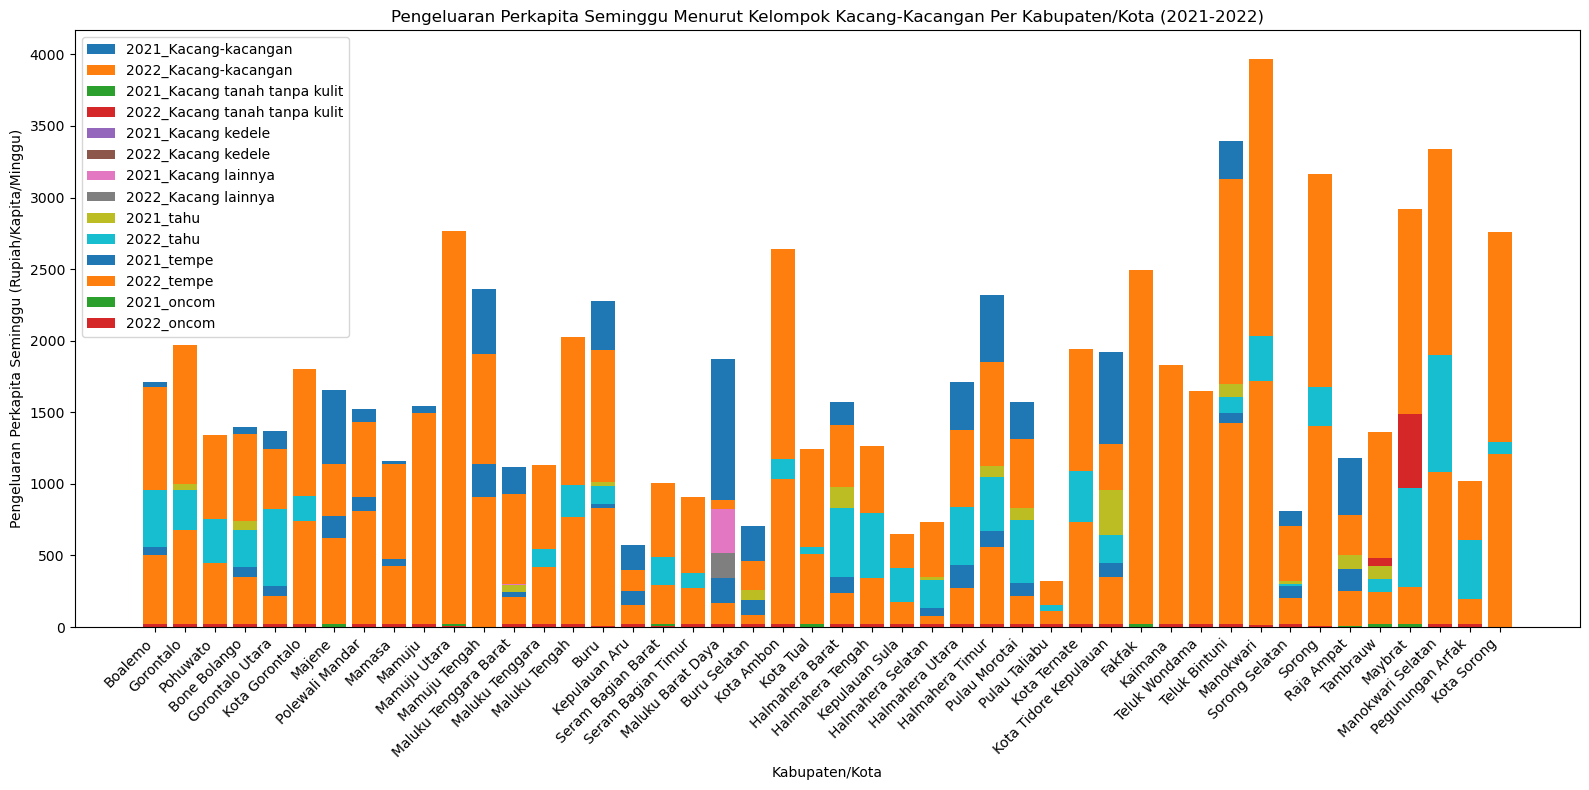

In [40]:
# Ambil data yang diperlukan untuk visualisasi
visualization_data = selected_timur_lainnya.toPandas()

# Set up plot
plt.figure(figsize=(16, 8))

# Loop untuk setiap kolom kecuali Kabupaten/Kota
for col in visualization_data.columns[1:]:
    plt.bar(visualization_data["Kabupaten/Kota"], visualization_data[col], label=col)

# Tambahkan label dan judul
plt.xlabel("Kabupaten/Kota")
plt.ylabel("Pengeluaran Perkapita Seminggu (Rupiah/Kapita/Minggu)")
plt.title("Pengeluaran Perkapita Seminggu Menurut Kelompok Kacang-Kacangan Per Kabupaten/Kota (2021-2022)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Tampilkan plot
plt.show()

### 2. Analisa Setelah Melakukan BisectingKMeans

#### Ini merupakah analisa yang dipergunakan dalam laporan

Menampilkan nilai rata-rata tahun 2021 dan nilai rata-rata tahun 2022

In [41]:
# menghitung nilai rata-rata antara kolom-kolom yang sesuai untuk tahun 2021 dan 2022, 
# dan kemudian membuat kolom baru untuk setiap jenis kacang dengan nilai rata-rata tersebut. 

df_result = BKMeans_transform.withColumn(
    "avg_kacang", 
    (F.col("2021_Kacang-kacangan") + F.col("2022_Kacang-kacangan")) / 2
).withColumn(
    "avg_kacang-tanah", 
    (F.col("2021_Kacang tanah tanpa kulit") + F.col("2022_Kacang tanah tanpa kulit")) / 2
).withColumn(
    "avg_kacang-kedele", 
    (F.col("2021_Kacang kedele") + F.col("2022_Kacang kedele")) / 2
).withColumn(
    "avg_kacang-lain", 
    (F.col("2021_Kacang lainnya") + F.col("2022_Kacang lainnya")) / 2
).withColumn(
    "avg_tahu", 
    (F.col("2021_tahu") + F.col("2022_tahu")) / 2
).withColumn(
    "avg_tempe", 
    (F.col("2021_tempe") + F.col("2022_tempe")) / 2
).withColumn(
    "avg_oncom", 
    (F.col("2021_oncom") + F.col("2022_oncom")) / 2
).select(
    "Kabupaten/Kota", "2021_Kacang-kacangan", "2022_Kacang-kacangan", "2021_Kacang tanah tanpa kulit", 
    "2022_Kacang tanah tanpa kulit", "2021_Kacang kedele", "2022_Kacang kedele", "2021_Kacang lainnya", 
    "2022_Kacang lainnya", "2021_tahu", "2022_tahu", "2021_tempe", "2022_tempe", "2021_oncom", "2022_oncom", "prediction")

df_result.show()

+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+----------+
| Kabupaten/Kota|2021_Kacang-kacangan|2022_Kacang-kacangan|2021_Kacang tanah tanpa kulit|2022_Kacang tanah tanpa kulit|2021_Kacang kedele|2022_Kacang kedele|2021_Kacang lainnya|2022_Kacang lainnya|2021_tahu|2022_tahu|2021_tempe|2022_tempe|2021_oncom|2022_oncom|prediction|
+---------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------+------------------+-------------------+-------------------+---------+---------+----------+----------+----------+----------+----------+
|       Simeulue|              475.28|              582.48|                         44.9|                        18.95|             14.02|             15.37|              33.89|    

In [42]:
#mengelompokkan berdasarkan prediction dan menghitung nilai rata rata keseluruhan 
#tujuan dari kode ini adalah untuk menghitung rata-rata dari beberapa kolom berdasarkan nilai pada kolom "prediction" dan menampilkannya menggunakan metode show(). 
#Outputnya akan berupa DataFrame yang menunjukkan nilai rata-rata untuk setiap kategori "prediction" pada kolom yang dihitung.

avg_growth_by_cluster = (
    df_result
    .groupBy("Kabupaten/Kota", "prediction")
    .agg(
        F.mean(df_result["2021_Kacang-kacangan"]).alias("avg_kacang_2021"),
        F.mean(df_result["2022_Kacang-kacangan"]).alias("avg_kacang_2022"),
        F.mean(df_result["2021_Kacang tanah tanpa kulit"]).alias("avg_kacang-tanah_2021"),
        F.mean(df_result["2022_Kacang tanah tanpa kulit"]).alias("avg_kacang-tanah_2022"),
        F.mean(df_result["2021_Kacang kedele"]).alias("avg_kacang-kedele_2021"),
        F.mean(df_result["2022_Kacang kedele"]).alias("avg_kacang-kedele_2022"),
        F.mean(df_result["2021_Kacang lainnya"]).alias("avg_kacang-lain_2021"),
        F.mean(df_result["2022_Kacang lainnya"]).alias("avg_kacang-lain_2022"),
        F.mean(df_result["2021_tahu"]).alias("avg_tahu_2021"),
        F.mean(df_result["2022_tahu"]).alias("avg_tahu_2022"),
        F.mean(df_result["2021_tempe"]).alias("avg_tempe_2021"),
        F.mean(df_result["2022_tempe"]).alias("avg_tempe_2022"),
        F.mean(df_result["2021_oncom"]).alias("avg_oncom_2021"),
        F.mean(df_result["2022_oncom"]).alias("avg_oncom_2022"),
    )
)

avg_growth_by_cluster.show()

+-----------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|   Kabupaten/Kota|prediction|avg_kacang_2021|avg_kacang_2022|avg_kacang-tanah_2021|avg_kacang-tanah_2022|avg_kacang-kedele_2021|avg_kacang-kedele_2022|avg_kacang-lain_2021|avg_kacang-lain_2022|avg_tahu_2021|avg_tahu_2022|avg_tempe_2021|avg_tempe_2022|avg_oncom_2021|avg_oncom_2022|
+-----------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|     Kota Tomohon|         2|        2529.37|        2496.62|                97.15|                138.1|                 14.02|                  6.99

Menampilkan nilai rata-rata dari cluster 0

In [43]:
# Filter untuk prediction = 0
avg_kacang_kacangan_prediction_0 = avg_growth_by_cluster.filter(F.col('prediction') == 0)

# Tampilkan hasil
avg_kacang_kacangan_prediction_0.show()


+-----------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|   Kabupaten/Kota|prediction|avg_kacang_2021|avg_kacang_2022|avg_kacang-tanah_2021|avg_kacang-tanah_2022|avg_kacang-kedele_2021|avg_kacang-kedele_2022|avg_kacang-lain_2021|avg_kacang-lain_2022|avg_tahu_2021|avg_tahu_2022|avg_tempe_2021|avg_tempe_2022|avg_oncom_2021|avg_oncom_2022|
+-----------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|             Buol|         0|        1640.47|         1354.7|               224.28|                63.21|                 14.02|                 15.37

In [44]:
# Menghitung rata-rata dari kolom "avg_kacang_2021", "avg_kacang_2022", dll. untuk prediction 0
avg_kacang_kacangan_prediction_0_avg = (
    avg_kacang_kacangan_prediction_0
    .agg(
        F.mean(F.col("avg_kacang_2021")).alias("avg_kacang_2021_avg"),
        F.mean(F.col("avg_kacang_2022")).alias("avg_kacang_2022_avg"),
        F.mean(F.col("avg_kacang-tanah_2021")).alias("avg_kacang-tanah_2021_avg"),
        F.mean(F.col("avg_kacang-tanah_2022")).alias("avg_kacang-tanah_2022_avg"),
        F.mean(F.col("avg_kacang-kedele_2021")).alias("avg_kacang-kedele_2021_avg"),
        F.mean(F.col("avg_kacang-kedele_2022")).alias("avg_kacang-kedele_2022_avg"),
        F.mean(F.col("avg_kacang-lain_2021")).alias("avg_kacang-lain_2021_avg"),
        F.mean(F.col("avg_kacang-lain_2022")).alias("avg_kacang-lain_2022_avg"),
        F.mean(F.col("avg_tahu_2021")).alias("avg_tahu_2021_avg"),
        F.mean(F.col("avg_tahu_2022")).alias("avg_tahu_2022_avg"),
        F.mean(F.col("avg_tempe_2021")).alias("avg_tempe_2021_avg"),
        F.mean(F.col("avg_tempe_2022")).alias("avg_tempe_2022_avg"),
        F.mean(F.col("avg_oncom_2021")).alias("avg_oncom_2021_avg"),
        F.mean(F.col("avg_oncom_2022")).alias("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_0_avg.show()


# Format dua angka desimal pada output
avg_kacang_kacangan_prediction_0_avg_rounded = avg_kacang_kacangan_prediction_0_avg.select(
    F.round("avg_kacang_2021_avg", 2).alias("avg_kacang_2021_avg"),
    F.round("avg_kacang_2022_avg", 2).alias("avg_kacang_2022_avg"),
    F.round("avg_kacang-tanah_2021_avg", 2).alias("avg_kacang-tanah_2021_avg"),
    F.round("avg_kacang-tanah_2022_avg", 2).alias("avg_kacang-tanah_2022_avg"),
    F.round("avg_kacang-kedele_2021_avg", 2).alias("avg_kacang-kedele_2021_avg"),
    F.round("avg_kacang-kedele_2022_avg", 2).alias("avg_kacang-kedele_2022_avg"),
    F.round("avg_kacang-lain_2021_avg", 2).alias("avg_kacang-lain_2021_avg"),
    F.round("avg_kacang-lain_2022_avg", 2).alias("avg_kacang-lain_2022_avg"),
    F.round("avg_tahu_2021_avg", 2).alias("avg_tahu_2021_avg"),
    F.round("avg_tahu_2022_avg", 2).alias("avg_tahu_2022_avg"),
    F.round("avg_tempe_2021_avg", 2).alias("avg_tempe_2021_avg"),
    F.round("avg_tempe_2022_avg", 2).alias("avg_tempe_2022_avg"),
    F.round("avg_oncom_2021_avg", 2).alias("avg_oncom_2021_avg"),
    F.round("avg_oncom_2022_avg", 2).alias("avg_oncom_2022_avg")
)

# Menambahkan kolom avg_total_avg
avg_kacang_kacangan_prediction_0_avg_total = avg_kacang_kacangan_prediction_0_avg_rounded.withColumn(
    "avg_total_avg",
    (
        F.col("avg_kacang_2021_avg") +
        F.col("avg_kacang_2022_avg") +
        F.col("avg_kacang-tanah_2021_avg") +
        F.col("avg_kacang-tanah_2022_avg") +
        F.col("avg_kacang-kedele_2021_avg") +
        F.col("avg_kacang-kedele_2022_avg") +
        F.col("avg_kacang-lain_2021_avg") +
        F.col("avg_kacang-lain_2022_avg") +
        F.col("avg_tahu_2021_avg") +
        F.col("avg_tahu_2022_avg") +
        F.col("avg_tempe_2021_avg") +
        F.col("avg_tempe_2022_avg") +
        F.col("avg_oncom_2021_avg") +
        F.col("avg_oncom_2022_avg")
    )
)

# Tampilkan hasil
avg_kacang_kacangan_prediction_0_avg_total.show()


+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|avg_kacang_2021_avg|avg_kacang_2022_avg|avg_kacang-tanah_2021_avg|avg_kacang-tanah_2022_avg|avg_kacang-kedele_2021_avg|avg_kacang-kedele_2022_avg|avg_kacang-lain_2021_avg|avg_kacang-lain_2022_avg|avg_tahu_2021_avg|avg_tahu_2022_avg|avg_tempe_2021_avg|avg_tempe_2022_avg|avg_oncom_2021_avg|avg_oncom_2022_avg|    avg_total_avg|
+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|             11

Menampilkan nilai rata-rata dari cluster 1

In [45]:
# Filter untuk prediction = 1
avg_kacang_kacangan_prediction_1 = avg_growth_by_cluster.filter(F.col('prediction') == 1)

# Tampilkan hasil
avg_kacang_kacangan_prediction_1.show()


+--------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|      Kabupaten/Kota|prediction|avg_kacang_2021|avg_kacang_2022|avg_kacang-tanah_2021|avg_kacang-tanah_2022|avg_kacang-kedele_2021|avg_kacang-kedele_2022|avg_kacang-lain_2021|avg_kacang-lain_2022|avg_tahu_2021|avg_tahu_2022|avg_tempe_2021|avg_tempe_2022|avg_oncom_2021|avg_oncom_2022|
+--------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|           Sijunjung|         1|        2014.47|        2114.14|                66.69|                22.64|                 14.02|          

In [46]:
# Menghitung rata-rata dari kolom "avg_kacang_2021", "avg_kacang_2022", dll. untuk prediction 0
avg_kacang_kacangan_prediction_1_avg = (
    avg_kacang_kacangan_prediction_1
    .agg(
        F.mean(F.col("avg_kacang_2021")).alias("avg_kacang_2021_avg"),
        F.mean(F.col("avg_kacang_2022")).alias("avg_kacang_2022_avg"),
        F.mean(F.col("avg_kacang-tanah_2021")).alias("avg_kacang-tanah_2021_avg"),
        F.mean(F.col("avg_kacang-tanah_2022")).alias("avg_kacang-tanah_2022_avg"),
        F.mean(F.col("avg_kacang-kedele_2021")).alias("avg_kacang-kedele_2021_avg"),
        F.mean(F.col("avg_kacang-kedele_2022")).alias("avg_kacang-kedele_2022_avg"),
        F.mean(F.col("avg_kacang-lain_2021")).alias("avg_kacang-lain_2021_avg"),
        F.mean(F.col("avg_kacang-lain_2022")).alias("avg_kacang-lain_2022_avg"),
        F.mean(F.col("avg_tahu_2021")).alias("avg_tahu_2021_avg"),
        F.mean(F.col("avg_tahu_2022")).alias("avg_tahu_2022_avg"),
        F.mean(F.col("avg_tempe_2021")).alias("avg_tempe_2021_avg"),
        F.mean(F.col("avg_tempe_2022")).alias("avg_tempe_2022_avg"),
        F.mean(F.col("avg_oncom_2021")).alias("avg_oncom_2021_avg"),
        F.mean(F.col("avg_oncom_2022")).alias("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_1_avg.show()


# Menambahkan kolom avg_total
avg_kacang_kacangan_prediction_1_avg = avg_kacang_kacangan_prediction_1_avg.withColumn(
    "avg_total_avg",
    (
        F.col("avg_kacang_2021_avg") +
        F.col("avg_kacang_2022_avg") +
        F.col("avg_kacang-tanah_2021_avg") +
        F.col("avg_kacang-tanah_2022_avg") +
        F.col("avg_kacang-kedele_2021_avg") +
        F.col("avg_kacang-kedele_2022_avg") +
        F.col("avg_kacang-lain_2021_avg") +
        F.col("avg_kacang-lain_2022_avg") +
        F.col("avg_tahu_2021_avg") +
        F.col("avg_tahu_2022_avg") +
        F.col("avg_tempe_2021_avg") +
        F.col("avg_tempe_2022_avg") +
        F.col("avg_oncom_2021_avg") +
        F.col("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_1_avg.show()


# Format dua angka desimal pada output
avg_kacang_kacangan_prediction_1_avg_rounded = avg_kacang_kacangan_prediction_1_avg.select(
    F.round("avg_kacang_2021_avg", 2).alias("avg_kacang_2021_avg"),
    F.round("avg_kacang_2022_avg", 2).alias("avg_kacang_2022_avg"),
    F.round("avg_kacang-tanah_2021_avg", 2).alias("avg_kacang-tanah_2021_avg"),
    F.round("avg_kacang-tanah_2022_avg", 2).alias("avg_kacang-tanah_2022_avg"),
    F.round("avg_kacang-kedele_2021_avg", 2).alias("avg_kacang-kedele_2021_avg"),
    F.round("avg_kacang-kedele_2022_avg", 2).alias("avg_kacang-kedele_2022_avg"),
    F.round("avg_kacang-lain_2021_avg", 2).alias("avg_kacang-lain_2021_avg"),
    F.round("avg_kacang-lain_2022_avg", 2).alias("avg_kacang-lain_2022_avg"),
    F.round("avg_tahu_2021_avg", 2).alias("avg_tahu_2021_avg"),
    F.round("avg_tahu_2022_avg", 2).alias("avg_tahu_2022_avg"),
    F.round("avg_tempe_2021_avg", 2).alias("avg_tempe_2021_avg"),
    F.round("avg_tempe_2022_avg", 2).alias("avg_tempe_2022_avg"),
    F.round("avg_oncom_2021_avg", 2).alias("avg_oncom_2021_avg"),
    F.round("avg_oncom_2022_avg", 2).alias("avg_oncom_2022_avg"),
    F.round("avg_total_avg", 2).alias("avg_total_avg")
)

# Tampilkan hasil
avg_kacang_kacangan_prediction_1_avg_rounded.show()



+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|avg_kacang_2021_avg|avg_kacang_2022_avg|avg_kacang-tanah_2021_avg|avg_kacang-tanah_2022_avg|avg_kacang-kedele_2021_avg|avg_kacang-kedele_2022_avg|avg_kacang-lain_2021_avg|avg_kacang-lain_2022_avg|avg_tahu_2021_avg|avg_tahu_2022_avg|avg_tempe_2021_avg|avg_tempe_2022_avg|avg_oncom_2021_avg|avg_oncom_2022_avg|avg_total_avg|
+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|            1922.81|       

Menampilkan nilai rata-rata dari cluster 2

In [47]:
# Filter untuk prediction = 2
avg_kacang_kacangan_prediction_2 = avg_growth_by_cluster.filter(F.col('prediction') == 2)

# Tampilkan hasil
avg_kacang_kacangan_prediction_2.show()


+------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|    Kabupaten/Kota|prediction|avg_kacang_2021|avg_kacang_2022|avg_kacang-tanah_2021|avg_kacang-tanah_2022|avg_kacang-kedele_2021|avg_kacang-kedele_2022|avg_kacang-lain_2021|avg_kacang-lain_2022|avg_tahu_2021|avg_tahu_2022|avg_tempe_2021|avg_tempe_2022|avg_oncom_2021|avg_oncom_2022|
+------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|      Kota Tomohon|         2|        2529.37|        2496.62|                97.15|                138.1|                 14.02|                  

In [48]:
# Menghitung rata-rata dari kolom "avg_kacang_2021", "avg_kacang_2022", dll. untuk prediction 0
avg_kacang_kacangan_prediction_2_avg = (
    avg_kacang_kacangan_prediction_2
    .agg(
        F.mean(F.col("avg_kacang_2021")).alias("avg_kacang_2021_avg"),
        F.mean(F.col("avg_kacang_2022")).alias("avg_kacang_2022_avg"),
        F.mean(F.col("avg_kacang-tanah_2021")).alias("avg_kacang-tanah_2021_avg"),
        F.mean(F.col("avg_kacang-tanah_2022")).alias("avg_kacang-tanah_2022_avg"),
        F.mean(F.col("avg_kacang-kedele_2021")).alias("avg_kacang-kedele_2021_avg"),
        F.mean(F.col("avg_kacang-kedele_2022")).alias("avg_kacang-kedele_2022_avg"),
        F.mean(F.col("avg_kacang-lain_2021")).alias("avg_kacang-lain_2021_avg"),
        F.mean(F.col("avg_kacang-lain_2022")).alias("avg_kacang-lain_2022_avg"),
        F.mean(F.col("avg_tahu_2021")).alias("avg_tahu_2021_avg"),
        F.mean(F.col("avg_tahu_2022")).alias("avg_tahu_2022_avg"),
        F.mean(F.col("avg_tempe_2021")).alias("avg_tempe_2021_avg"),
        F.mean(F.col("avg_tempe_2022")).alias("avg_tempe_2022_avg"),
        F.mean(F.col("avg_oncom_2021")).alias("avg_oncom_2021_avg"),
        F.mean(F.col("avg_oncom_2022")).alias("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_2_avg.show()

# Menambahkan kolom avg_total
avg_kacang_kacangan_prediction_2_avg = avg_kacang_kacangan_prediction_2_avg.withColumn(
    "avg_total_avg",
    (
        F.col("avg_kacang_2021_avg") +
        F.col("avg_kacang_2022_avg") +
        F.col("avg_kacang-tanah_2021_avg") +
        F.col("avg_kacang-tanah_2022_avg") +
        F.col("avg_kacang-kedele_2021_avg") +
        F.col("avg_kacang-kedele_2022_avg") +
        F.col("avg_kacang-lain_2021_avg") +
        F.col("avg_kacang-lain_2022_avg") +
        F.col("avg_tahu_2021_avg") +
        F.col("avg_tahu_2022_avg") +
        F.col("avg_tempe_2021_avg") +
        F.col("avg_tempe_2022_avg") +
        F.col("avg_oncom_2021_avg") +
        F.col("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_1_avg.show()


# Format dua angka desimal pada output
avg_kacang_kacangan_prediction_2_avg_rounded = avg_kacang_kacangan_prediction_2_avg.select(
    F.round("avg_kacang_2021_avg", 2).alias("avg_kacang_2021_avg"),
    F.round("avg_kacang_2022_avg", 2).alias("avg_kacang_2022_avg"),
    F.round("avg_kacang-tanah_2021_avg", 2).alias("avg_kacang-tanah_2021_avg"),
    F.round("avg_kacang-tanah_2022_avg", 2).alias("avg_kacang-tanah_2022_avg"),
    F.round("avg_kacang-kedele_2021_avg", 2).alias("avg_kacang-kedele_2021_avg"),
    F.round("avg_kacang-kedele_2022_avg", 2).alias("avg_kacang-kedele_2022_avg"),
    F.round("avg_kacang-lain_2021_avg", 2).alias("avg_kacang-lain_2021_avg"),
    F.round("avg_kacang-lain_2022_avg", 2).alias("avg_kacang-lain_2022_avg"),
    F.round("avg_tahu_2021_avg", 2).alias("avg_tahu_2021_avg"),
    F.round("avg_tahu_2022_avg", 2).alias("avg_tahu_2022_avg"),
    F.round("avg_tempe_2021_avg", 2).alias("avg_tempe_2021_avg"),
    F.round("avg_tempe_2022_avg", 2).alias("avg_tempe_2022_avg"),
    F.round("avg_oncom_2021_avg", 2).alias("avg_oncom_2021_avg"),
    F.round("avg_oncom_2022_avg", 2).alias("avg_oncom_2022_avg"),
    F.round("avg_total_avg", 2).alias("avg_total_avg")
)

# Tampilkan hasil
avg_kacang_kacangan_prediction_2_avg_rounded.show()



+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|avg_kacang_2021_avg|avg_kacang_2022_avg|avg_kacang-tanah_2021_avg|avg_kacang-tanah_2022_avg|avg_kacang-kedele_2021_avg|avg_kacang-kedele_2022_avg|avg_kacang-lain_2021_avg|avg_kacang-lain_2022_avg|avg_tahu_2021_avg|avg_tahu_2022_avg|avg_tempe_2021_avg|avg_tempe_2022_avg|avg_oncom_2021_avg|avg_oncom_2022_avg|avg_total_avg|
+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|            2358.23|       

Menampilkan nilai rata-rata dari cluster 3

In [49]:
# Filter untuk prediction = 3
avg_kacang_kacangan_prediction_3 = avg_growth_by_cluster.filter(F.col('prediction') == 3)

# Tampilkan hasil
avg_kacang_kacangan_prediction_3.show()


+--------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|      Kabupaten/Kota|prediction|avg_kacang_2021|avg_kacang_2022|avg_kacang-tanah_2021|avg_kacang-tanah_2022|avg_kacang-kedele_2021|avg_kacang-kedele_2022|avg_kacang-lain_2021|avg_kacang-lain_2022|avg_tahu_2021|avg_tahu_2022|avg_tempe_2021|avg_tempe_2022|avg_oncom_2021|avg_oncom_2022|
+--------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|       Bandung Barat|         3|         2539.8|        3440.39|                21.38|                39.61|                  3.64|          

In [50]:
# Menghitung rata-rata dari kolom "avg_kacang_2021", "avg_kacang_2022", dll. untuk prediction 0
avg_kacang_kacangan_prediction_3_avg = (
    avg_kacang_kacangan_prediction_3
    .agg(
        F.mean(F.col("avg_kacang_2021")).alias("avg_kacang_2021_avg"),
        F.mean(F.col("avg_kacang_2022")).alias("avg_kacang_2022_avg"),
        F.mean(F.col("avg_kacang-tanah_2021")).alias("avg_kacang-tanah_2021_avg"),
        F.mean(F.col("avg_kacang-tanah_2022")).alias("avg_kacang-tanah_2022_avg"),
        F.mean(F.col("avg_kacang-kedele_2021")).alias("avg_kacang-kedele_2021_avg"),
        F.mean(F.col("avg_kacang-kedele_2022")).alias("avg_kacang-kedele_2022_avg"),
        F.mean(F.col("avg_kacang-lain_2021")).alias("avg_kacang-lain_2021_avg"),
        F.mean(F.col("avg_kacang-lain_2022")).alias("avg_kacang-lain_2022_avg"),
        F.mean(F.col("avg_tahu_2021")).alias("avg_tahu_2021_avg"),
        F.mean(F.col("avg_tahu_2022")).alias("avg_tahu_2022_avg"),
        F.mean(F.col("avg_tempe_2021")).alias("avg_tempe_2021_avg"),
        F.mean(F.col("avg_tempe_2022")).alias("avg_tempe_2022_avg"),
        F.mean(F.col("avg_oncom_2021")).alias("avg_oncom_2021_avg"),
        F.mean(F.col("avg_oncom_2022")).alias("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_3_avg.show()

# Menambahkan kolom avg_total
avg_kacang_kacangan_prediction_3_avg = avg_kacang_kacangan_prediction_3_avg.withColumn(
    "avg_total_avg",
    (
        F.col("avg_kacang_2021_avg") +
        F.col("avg_kacang_2022_avg") +
        F.col("avg_kacang-tanah_2021_avg") +
        F.col("avg_kacang-tanah_2022_avg") +
        F.col("avg_kacang-kedele_2021_avg") +
        F.col("avg_kacang-kedele_2022_avg") +
        F.col("avg_kacang-lain_2021_avg") +
        F.col("avg_kacang-lain_2022_avg") +
        F.col("avg_tahu_2021_avg") +
        F.col("avg_tahu_2022_avg") +
        F.col("avg_tempe_2021_avg") +
        F.col("avg_tempe_2022_avg") +
        F.col("avg_oncom_2021_avg") +
        F.col("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_3_avg.show()


# Format dua angka desimal pada output
avg_kacang_kacangan_prediction_3_avg_rounded = avg_kacang_kacangan_prediction_3_avg.select(
    F.round("avg_kacang_2021_avg", 2).alias("avg_kacang_2021_avg"),
    F.round("avg_kacang_2022_avg", 2).alias("avg_kacang_2022_avg"),
    F.round("avg_kacang-tanah_2021_avg", 2).alias("avg_kacang-tanah_2021_avg"),
    F.round("avg_kacang-tanah_2022_avg", 2).alias("avg_kacang-tanah_2022_avg"),
    F.round("avg_kacang-kedele_2021_avg", 2).alias("avg_kacang-kedele_2021_avg"),
    F.round("avg_kacang-kedele_2022_avg", 2).alias("avg_kacang-kedele_2022_avg"),
    F.round("avg_kacang-lain_2021_avg", 2).alias("avg_kacang-lain_2021_avg"),
    F.round("avg_kacang-lain_2022_avg", 2).alias("avg_kacang-lain_2022_avg"),
    F.round("avg_tahu_2021_avg", 2).alias("avg_tahu_2021_avg"),
    F.round("avg_tahu_2022_avg", 2).alias("avg_tahu_2022_avg"),
    F.round("avg_tempe_2021_avg", 2).alias("avg_tempe_2021_avg"),
    F.round("avg_tempe_2022_avg", 2).alias("avg_tempe_2022_avg"),
    F.round("avg_oncom_2021_avg", 2).alias("avg_oncom_2021_avg"),
    F.round("avg_oncom_2022_avg", 2).alias("avg_oncom_2022_avg"),
    F.round("avg_total_avg", 2).alias("avg_total_avg")
)

# Tampilkan hasil
avg_kacang_kacangan_prediction_3_avg_rounded.show()



+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|avg_kacang_2021_avg|avg_kacang_2022_avg|avg_kacang-tanah_2021_avg|avg_kacang-tanah_2022_avg|avg_kacang-kedele_2021_avg|avg_kacang-kedele_2022_avg|avg_kacang-lain_2021_avg|avg_kacang-lain_2022_avg|avg_tahu_2021_avg|avg_tahu_2022_avg|avg_tempe_2021_avg|avg_tempe_2022_avg|avg_oncom_2021_avg|avg_oncom_2022_avg|avg_total_avg|
+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|            2893.19|       

Menampilkan nilai rata-rata dari cluster 4

In [51]:
# Filter untuk prediction = 4
avg_kacang_kacangan_prediction_4 = avg_growth_by_cluster.filter(F.col('prediction') == 4)

# Tampilkan hasil
avg_kacang_kacangan_prediction_4.show()


+------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|    Kabupaten/Kota|prediction|avg_kacang_2021|avg_kacang_2022|avg_kacang-tanah_2021|avg_kacang-tanah_2022|avg_kacang-kedele_2021|avg_kacang-kedele_2022|avg_kacang-lain_2021|avg_kacang-lain_2022|avg_tahu_2021|avg_tahu_2022|avg_tempe_2021|avg_tempe_2022|avg_oncom_2021|avg_oncom_2022|
+------------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|        Kota Metro|         4|        3337.12|        3250.56|                99.22|                41.15|                 14.02|                  

In [52]:
# Menghitung rata-rata dari kolom "avg_kacang_2021", "avg_kacang_2022", dll. untuk prediction 0
avg_kacang_kacangan_prediction_4_avg = (
    avg_kacang_kacangan_prediction_4
    .agg(
        F.mean(F.col("avg_kacang_2021")).alias("avg_kacang_2021_avg"),
        F.mean(F.col("avg_kacang_2022")).alias("avg_kacang_2022_avg"),
        F.mean(F.col("avg_kacang-tanah_2021")).alias("avg_kacang-tanah_2021_avg"),
        F.mean(F.col("avg_kacang-tanah_2022")).alias("avg_kacang-tanah_2022_avg"),
        F.mean(F.col("avg_kacang-kedele_2021")).alias("avg_kacang-kedele_2021_avg"),
        F.mean(F.col("avg_kacang-kedele_2022")).alias("avg_kacang-kedele_2022_avg"),
        F.mean(F.col("avg_kacang-lain_2021")).alias("avg_kacang-lain_2021_avg"),
        F.mean(F.col("avg_kacang-lain_2022")).alias("avg_kacang-lain_2022_avg"),
        F.mean(F.col("avg_tahu_2021")).alias("avg_tahu_2021_avg"),
        F.mean(F.col("avg_tahu_2022")).alias("avg_tahu_2022_avg"),
        F.mean(F.col("avg_tempe_2021")).alias("avg_tempe_2021_avg"),
        F.mean(F.col("avg_tempe_2022")).alias("avg_tempe_2022_avg"),
        F.mean(F.col("avg_oncom_2021")).alias("avg_oncom_2021_avg"),
        F.mean(F.col("avg_oncom_2022")).alias("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_4_avg.show()

# Menambahkan kolom avg_total
avg_kacang_kacangan_prediction_4_avg = avg_kacang_kacangan_prediction_4_avg.withColumn(
    "avg_total_avg",
    (
        F.col("avg_kacang_2021_avg") +
        F.col("avg_kacang_2022_avg") +
        F.col("avg_kacang-tanah_2021_avg") +
        F.col("avg_kacang-tanah_2022_avg") +
        F.col("avg_kacang-kedele_2021_avg") +
        F.col("avg_kacang-kedele_2022_avg") +
        F.col("avg_kacang-lain_2021_avg") +
        F.col("avg_kacang-lain_2022_avg") +
        F.col("avg_tahu_2021_avg") +
        F.col("avg_tahu_2022_avg") +
        F.col("avg_tempe_2021_avg") +
        F.col("avg_tempe_2022_avg") +
        F.col("avg_oncom_2021_avg") +
        F.col("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_4_avg.show()


# Format dua angka desimal pada output
avg_kacang_kacangan_prediction_4_avg_rounded = avg_kacang_kacangan_prediction_4_avg.select(
    F.round("avg_kacang_2021_avg", 2).alias("avg_kacang_2021_avg"),
    F.round("avg_kacang_2022_avg", 2).alias("avg_kacang_2022_avg"),
    F.round("avg_kacang-tanah_2021_avg", 2).alias("avg_kacang-tanah_2021_avg"),
    F.round("avg_kacang-tanah_2022_avg", 2).alias("avg_kacang-tanah_2022_avg"),
    F.round("avg_kacang-kedele_2021_avg", 2).alias("avg_kacang-kedele_2021_avg"),
    F.round("avg_kacang-kedele_2022_avg", 2).alias("avg_kacang-kedele_2022_avg"),
    F.round("avg_kacang-lain_2021_avg", 2).alias("avg_kacang-lain_2021_avg"),
    F.round("avg_kacang-lain_2022_avg", 2).alias("avg_kacang-lain_2022_avg"),
    F.round("avg_tahu_2021_avg", 2).alias("avg_tahu_2021_avg"),
    F.round("avg_tahu_2022_avg", 2).alias("avg_tahu_2022_avg"),
    F.round("avg_tempe_2021_avg", 2).alias("avg_tempe_2021_avg"),
    F.round("avg_tempe_2022_avg", 2).alias("avg_tempe_2022_avg"),
    F.round("avg_oncom_2021_avg", 2).alias("avg_oncom_2021_avg"),
    F.round("avg_oncom_2022_avg", 2).alias("avg_oncom_2022_avg"),
    F.round("avg_total_avg", 2).alias("avg_total_avg")
)

# Tampilkan hasil
avg_kacang_kacangan_prediction_4_avg_rounded.show()



+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|avg_kacang_2021_avg|avg_kacang_2022_avg|avg_kacang-tanah_2021_avg|avg_kacang-tanah_2022_avg|avg_kacang-kedele_2021_avg|avg_kacang-kedele_2022_avg|avg_kacang-lain_2021_avg|avg_kacang-lain_2022_avg|avg_tahu_2021_avg|avg_tahu_2022_avg|avg_tempe_2021_avg|avg_tempe_2022_avg|avg_oncom_2021_avg|avg_oncom_2022_avg|avg_total_avg|
+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|            3456.81|       

Menampilkan nilai rata-rata dari cluster 5

In [53]:
# Filter untuk prediction = 5
avg_kacang_kacangan_prediction_5 = avg_growth_by_cluster.filter(F.col('prediction') == 5)

# Tampilkan hasil
avg_kacang_kacangan_prediction_5.show()


+--------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|Kabupaten/Kota|prediction|avg_kacang_2021|avg_kacang_2022|avg_kacang-tanah_2021|avg_kacang-tanah_2022|avg_kacang-kedele_2021|avg_kacang-kedele_2022|avg_kacang-lain_2021|avg_kacang-lain_2022|avg_tahu_2021|avg_tahu_2022|avg_tempe_2021|avg_tempe_2022|avg_oncom_2021|avg_oncom_2022|
+--------------+----------+---------------+---------------+---------------------+---------------------+----------------------+----------------------+--------------------+--------------------+-------------+-------------+--------------+--------------+--------------+--------------+
|   Kota Madiun|         5|        4142.13|        4856.41|               111.24|               100.96|                  1.22|                 11.51|           

In [54]:
# Menghitung rata-rata dari kolom "avg_kacang_2021", "avg_kacang_2022", dll. untuk prediction 0
avg_kacang_kacangan_prediction_5_avg = (
    avg_kacang_kacangan_prediction_5
    .agg(
        F.mean(F.col("avg_kacang_2021")).alias("avg_kacang_2021_avg"),
        F.mean(F.col("avg_kacang_2022")).alias("avg_kacang_2022_avg"),
        F.mean(F.col("avg_kacang-tanah_2021")).alias("avg_kacang-tanah_2021_avg"),
        F.mean(F.col("avg_kacang-tanah_2022")).alias("avg_kacang-tanah_2022_avg"),
        F.mean(F.col("avg_kacang-kedele_2021")).alias("avg_kacang-kedele_2021_avg"),
        F.mean(F.col("avg_kacang-kedele_2022")).alias("avg_kacang-kedele_2022_avg"),
        F.mean(F.col("avg_kacang-lain_2021")).alias("avg_kacang-lain_2021_avg"),
        F.mean(F.col("avg_kacang-lain_2022")).alias("avg_kacang-lain_2022_avg"),
        F.mean(F.col("avg_tahu_2021")).alias("avg_tahu_2021_avg"),
        F.mean(F.col("avg_tahu_2022")).alias("avg_tahu_2022_avg"),
        F.mean(F.col("avg_tempe_2021")).alias("avg_tempe_2021_avg"),
        F.mean(F.col("avg_tempe_2022")).alias("avg_tempe_2022_avg"),
        F.mean(F.col("avg_oncom_2021")).alias("avg_oncom_2021_avg"),
        F.mean(F.col("avg_oncom_2022")).alias("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_5_avg.show()

# Menambahkan kolom avg_total
avg_kacang_kacangan_prediction_5_avg = avg_kacang_kacangan_prediction_5_avg.withColumn(
    "avg_total_avg",
    (
        F.col("avg_kacang_2021_avg") +
        F.col("avg_kacang_2022_avg") +
        F.col("avg_kacang-tanah_2021_avg") +
        F.col("avg_kacang-tanah_2022_avg") +
        F.col("avg_kacang-kedele_2021_avg") +
        F.col("avg_kacang-kedele_2022_avg") +
        F.col("avg_kacang-lain_2021_avg") +
        F.col("avg_kacang-lain_2022_avg") +
        F.col("avg_tahu_2021_avg") +
        F.col("avg_tahu_2022_avg") +
        F.col("avg_tempe_2021_avg") +
        F.col("avg_tempe_2022_avg") +
        F.col("avg_oncom_2021_avg") +
        F.col("avg_oncom_2022_avg")
    )
)

# # Tampilkan hasil
# avg_kacang_kacangan_prediction_5_avg.show()


# Format dua angka desimal pada output
avg_kacang_kacangan_prediction_5_avg_rounded = avg_kacang_kacangan_prediction_5_avg.select(
    F.round("avg_kacang_2021_avg", 2).alias("avg_kacang_2021_avg"),
    F.round("avg_kacang_2022_avg", 2).alias("avg_kacang_2022_avg"),
    F.round("avg_kacang-tanah_2021_avg", 2).alias("avg_kacang-tanah_2021_avg"),
    F.round("avg_kacang-tanah_2022_avg", 2).alias("avg_kacang-tanah_2022_avg"),
    F.round("avg_kacang-kedele_2021_avg", 2).alias("avg_kacang-kedele_2021_avg"),
    F.round("avg_kacang-kedele_2022_avg", 2).alias("avg_kacang-kedele_2022_avg"),
    F.round("avg_kacang-lain_2021_avg", 2).alias("avg_kacang-lain_2021_avg"),
    F.round("avg_kacang-lain_2022_avg", 2).alias("avg_kacang-lain_2022_avg"),
    F.round("avg_tahu_2021_avg", 2).alias("avg_tahu_2021_avg"),
    F.round("avg_tahu_2022_avg", 2).alias("avg_tahu_2022_avg"),
    F.round("avg_tempe_2021_avg", 2).alias("avg_tempe_2021_avg"),
    F.round("avg_tempe_2022_avg", 2).alias("avg_tempe_2022_avg"),
    F.round("avg_oncom_2021_avg", 2).alias("avg_oncom_2021_avg"),
    F.round("avg_oncom_2022_avg", 2).alias("avg_oncom_2022_avg"),
    F.round("avg_total_avg", 2).alias("avg_total_avg")
)

# Tampilkan hasil
avg_kacang_kacangan_prediction_5_avg_rounded.show()



+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|avg_kacang_2021_avg|avg_kacang_2022_avg|avg_kacang-tanah_2021_avg|avg_kacang-tanah_2022_avg|avg_kacang-kedele_2021_avg|avg_kacang-kedele_2022_avg|avg_kacang-lain_2021_avg|avg_kacang-lain_2022_avg|avg_tahu_2021_avg|avg_tahu_2022_avg|avg_tempe_2021_avg|avg_tempe_2022_avg|avg_oncom_2021_avg|avg_oncom_2022_avg|avg_total_avg|
+-------------------+-------------------+-------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------+
|            4226.22|       

### _Analisa Gambaran Umum_ 

In [88]:
avg_kacang_values_2021 = [
    (avg_kacang_kacangan_by_prediction.select("avg_kacang").collect()[0][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang").collect()[1][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_kacang-tanah").collect()[0][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang-tanah").collect()[1][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_kacang-kedele").collect()[0][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang-kedele").collect()[1][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_kacang-lain").collect()[0][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang-lain").collect()[1][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_tahu").collect()[0][0] +
     avg_kacang_kacangan_by_prediction.select("avg_tahu").collect()[1][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_tempe").collect()[0][0] +
     avg_kacang_kacangan_by_prediction.select("avg_tempe").collect()[1][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_oncom").collect()[0][0] +
     avg_kacang_kacangan_by_prediction.select("avg_oncom").collect()[1][0])
]

avg_kacang_values_2022 = [
    (avg_kacang_kacangan_by_prediction.select("avg_kacang").collect()[2][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang").collect()[3][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_kacang-tanah").collect()[2][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang-tanah").collect()[3][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_kacang-kedele").collect()[2][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang-kedele").collect()[3][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_kacang-lain").collect()[2][0] +
     avg_kacang_kacangan_by_prediction.select("avg_kacang-lain").collect()[3][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_tahu").collect()[2][0] +
     avg_kacang_kacangan_by_prediction.select("avg_tahu").collect()[3][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_tempe").collect()[2][0] +
     avg_kacang_kacangan_by_prediction.select("avg_tempe").collect()[3][0]),
    (avg_kacang_kacangan_by_prediction.select("avg_oncom").collect()[2][0] +
     avg_kacang_kacangan_by_prediction.select("avg_oncom").collect()[3][0])
]

jenis_kacang_tertinggi = max(zip(
    ["kacang", "kacang-tanah", "kacang-kedele", "kacang-lain", "tahu", "tempe", "oncom"],
    avg_kacang_values_2021, avg_kacang_values_2022
), key=lambda x: max(x[1], x[2]))

jenis_kacang_terendah = min(zip(
    ["kacang", "kacang-tanah", "kacang-kedele", "kacang-lain", "tahu", "tempe", "oncom"],
    avg_kacang_values_2021, avg_kacang_values_2022
), key=lambda x: max(x[1], x[2]))


In [89]:
# Menghitung nilai rata-rata
avg_2021 = sum(avg_kacang_values_2021) / len(avg_kacang_values_2021)
avg_2022 = sum(avg_kacang_values_2022) / len(avg_kacang_values_2022)

In [90]:
# Menampilkan nilai rata-rata 2021 dan 2022 dengan tiga angka di belakang koma
print(f"Nilai rata-rata 2021: {avg_2021:.3f}")
print(f"Nilai rata-rata 2022: {avg_2022:.3f}")

# Menampilkan jenis kacang dengan rata-rata tertinggi dan terendah dengan tiga angka di belakang koma
print(f"Jenis kacang dengan rata-rata tertinggi di tahun 2021 dan 2022: {jenis_kacang_tertinggi[0]}")
print(f"Jenis kacang dengan rata-rata terendah di tahun 2021 dan 2022: {jenis_kacang_terendah[0]}")


Nilai rata-rata 2021: 1151.256
Nilai rata-rata 2022: 1384.391
Jenis kacang dengan rata-rata tertinggi di tahun 2021 dan 2022: kacang
Jenis kacang dengan rata-rata terendah di tahun 2021 dan 2022: kacang-kedele


### _Analisa Untuk Tahun 2021 - 2022_ 

In [59]:
from pyspark.sql import functions as F

# Menghitung rata-rata dari keseluruhan jenis kacang
avg_kacang_kacangan_by_prediction = (
    avg_growth_by_cluster
    .withColumn(
        "avg_kacang", 
        (F.col("avg_kacang_2021") + F.col("avg_kacang_2022")) / 2
    )
    .withColumn(
        "avg_kacang-tanah", 
        (F.col("avg_kacang-tanah_2021") + F.col("avg_kacang-tanah_2022")) / 2
    )
    .withColumn(
        "avg_kacang-kedele", 
        (F.col("avg_kacang-kedele_2021") + F.col("avg_kacang-kedele_2022")) / 2
    )
    .withColumn(
        "avg_kacang-lain", 
        (F.col("avg_kacang-lain_2021") + F.col("avg_kacang-lain_2022")) / 2
    )
    .withColumn(
        "avg_tahu", 
        (F.col("avg_tahu_2021") + F.col("avg_tahu_2022")) / 2
    )
    .withColumn(
        "avg_tempe", 
        (F.col("avg_tempe_2021") + F.col("avg_tempe_2022")) / 2
    )
    .withColumn(
        "avg_oncom", 
        (F.col("avg_oncom_2021") + F.col("avg_oncom_2022")) / 2
    )
    .select(
        'Kabupaten/Kota', 'prediction',
        'avg_kacang', 'avg_kacang-tanah', 'avg_kacang-kedele', 'avg_kacang-lain',
        'avg_tahu', 'avg_tempe', 'avg_oncom'
    )
)

# Menambahkan kolom avg_total
avg_kacang_kacangan_by_prediction = avg_kacang_kacangan_by_prediction.withColumn(
    "avg_total",
    (
        F.col("avg_kacang") +
        F.col("avg_kacang-tanah") +
        F.col("avg_kacang-kedele") +
        F.col("avg_kacang-lain") +
        F.col("avg_tahu") +
        F.col("avg_tempe") +
        F.col("avg_oncom")
    )
)

# Menampilkan hasil
avg_kacang_kacangan_by_prediction.show()


+-----------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|   Kabupaten/Kota|prediction|        avg_kacang|  avg_kacang-tanah| avg_kacang-kedele|   avg_kacang-lain|          avg_tahu|         avg_tempe|         avg_oncom|         avg_total|
+-----------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     Kota Tomohon|         2|          2512.995|           117.625|10.504999999999999|           123.975|           1483.01|             768.8|             10.24|           5027.15|
|             Buol|         0|          1497.585|           143.745|            14.695|             35.76| 774.0899999999999|           543.985|             21.78|3031.6400000000003|
|           Paniai|         2|          2388.555|            153.75|            14.69

In [84]:
# Menghitung rata-rata total untuk tahun 2021 dan 2022
avg_kacang_kacangan_by_prediction = avg_kacang_kacangan_by_prediction.withColumn(
    "avg_total", F.col("avg_kacang") + F.col("avg_kacang-tanah") + F.col("avg_kacang-kedele") +
                 F.col("avg_kacang-lain") + F.col("avg_tahu") + F.col("avg_tempe") + F.col("avg_oncom")
)

# Menentukan jenis kacang dengan rata-rata tertinggi
jenis_kacang_tertinggi = avg_kacang_kacangan_by_prediction.select(
    "Kabupaten/Kota",
    "prediction",
    "avg_kacang",
    "avg_kacang-tanah",
    "avg_kacang-kedele",
    "avg_kacang-lain",
    "avg_tahu",
    "avg_tempe",
    "avg_oncom",
    "avg_total"
).orderBy(F.desc("avg_total")).first()

# Menentukan jenis kacang dengan rata-rata terendah
jenis_kacang_terendah = avg_kacang_kacangan_by_prediction.select(
    "Kabupaten/Kota",
    "prediction",
    "avg_kacang",
    "avg_kacang-tanah",
    "avg_kacang-kedele",
    "avg_kacang-lain",
    "avg_tahu",
    "avg_tempe",
    "avg_oncom",
    "avg_total"
).orderBy(F.asc("avg_total")).first()

In [85]:
# Daftar jenis kacang
jenis_kacang_list = ["avg_kacang", "avg_kacang-tanah", "avg_kacang-kedele", 
                     "avg_kacang-lain", "avg_tahu", "avg_tempe", "avg_oncom"]

In [86]:
# Bubble sort untuk menentukan jenis kacang dengan rata-rata tertinggi
for i in range(len(jenis_kacang_list)):
    for j in range(0, len(jenis_kacang_list)-i-1):
        if jenis_kacang_tertinggi[jenis_kacang_list[j]] < jenis_kacang_tertinggi[jenis_kacang_list[j+1]]:
            jenis_kacang_list[j], jenis_kacang_list[j+1] = jenis_kacang_list[j+1], jenis_kacang_list[j]

# Menampilkan hasil rata-rata tertinggi
print("Jenis kacang dengan rata-rata tertinggi pada tahun 2021 dan 2022:")
print("Kabupaten/Kota:", jenis_kacang_tertinggi["Kabupaten/Kota"])
print("Prediction:", jenis_kacang_tertinggi["prediction"])
print("Rata-rata Total:", jenis_kacang_tertinggi["avg_total"])
print("Jenis kacang:", jenis_kacang_list[0])
print("urutan: ", jenis_kacang_list)

Jenis kacang dengan rata-rata tertinggi pada tahun 2021 dan 2022:
Kabupaten/Kota: Puncak Jaya
Prediction: 5
Rata-rata Total: 17392.515
Jenis kacang: avg_kacang
urutan:  ['avg_kacang', 'avg_kacang-tanah', 'avg_tahu', 'avg_tempe', 'avg_kacang-kedele', 'avg_kacang-lain', 'avg_oncom']


In [87]:
# Bubble sort untuk menentukan jenis kacang dengan rata-rata terendah
for i in range(len(jenis_kacang_list)):
    for j in range(0, len(jenis_kacang_list)-i-1):
        if jenis_kacang_terendah[jenis_kacang_list[j]] > jenis_kacang_terendah[jenis_kacang_list[j+1]]:
            jenis_kacang_list[j], jenis_kacang_list[j+1] = jenis_kacang_list[j+1], jenis_kacang_list[j]

# Menampilkan hasil rata-rata terendah
print("\nJenis kacang dengan rata-rata terendah pada tahun 2021 dan 2022:")
print("Kabupaten/Kota:", jenis_kacang_terendah["Kabupaten/Kota"])
print("Prediction:", jenis_kacang_terendah["prediction"])
print("Rata-rata Total:", jenis_kacang_terendah["avg_total"])
print("Jenis kacang:", jenis_kacang_list[0])
print("urutan: ", jenis_kacang_list)


Jenis kacang dengan rata-rata terendah pada tahun 2021 dan 2022:
Kabupaten/Kota: Pulau Taliabu
Prediction: 0
Rata-rata Total: 572.355
Jenis kacang: avg_kacang-kedele
urutan:  ['avg_kacang-kedele', 'avg_oncom', 'avg_kacang-tanah', 'avg_kacang-lain', 'avg_tempe', 'avg_tahu', 'avg_kacang']


### _Analisa Per Tahun_ 

In [55]:
nilai_rata_pertahun = avg_growth_by_cluster

# Menentukan jenis kacang dengan rata-rata tertinggi 2021
jenis_tertinggi_2021 = nilai_rata_pertahun.select(
    "Kabupaten/Kota",
    "prediction",
    "avg_kacang_2021",
    "avg_kacang-tanah_2021",
    "avg_kacang-kedele_2021",
    "avg_kacang-lain_2021",
    "avg_tahu_2021",
    "avg_tempe_2021",
    "avg_oncom_2021"
).orderBy(F.col("avg_kacang_2021").desc(),
    F.col("avg_kacang-tanah_2021").desc(),
    F.col("avg_kacang-kedele_2021").desc(),
    F.col("avg_kacang-lain_2021").desc(),
    F.col("avg_tahu_2021").desc(),
    F.col("avg_tempe_2021").desc(),
    F.col("avg_oncom_2021").desc()
).first()

# Menentukan jenis kacang dengan rata-rata terendah 2021
jenis_terendah_2021 = nilai_rata_pertahun.select(
    "Kabupaten/Kota",
    "prediction",
    "avg_kacang_2021",
    "avg_kacang-tanah_2021",
    "avg_kacang-kedele_2021",
    "avg_kacang-lain_2021",
    "avg_tahu_2021",
    "avg_tempe_2021",
    "avg_oncom_2021",
).orderBy(F.col("avg_kacang_2021").asc(),
    F.col("avg_kacang-tanah_2021").asc(),
    F.col("avg_kacang-kedele_2021").asc(),
    F.col("avg_kacang-lain_2021").asc(),
    F.col("avg_tahu_2021").asc(),
    F.col("avg_tempe_2021").asc(),
    F.col("avg_oncom_2021").asc()).first()

# Menentukan jenis kacang dengan rata-rata tertinggi 2022
jenis_tertinggi_2022 = nilai_rata_pertahun.select(
    "Kabupaten/Kota",
    "prediction",
    "avg_kacang_2022",
    "avg_kacang-tanah_2022",
    "avg_kacang-kedele_2022",
    "avg_kacang-lain_2022",
    "avg_tahu_2022",
    "avg_tempe_2022",
    "avg_oncom_2022"
).orderBy(F.col("avg_kacang_2022").desc(),
    F.col("avg_kacang-tanah_2022").desc(),
    F.col("avg_kacang-kedele_2022").desc(),
    F.col("avg_kacang-lain_2022").desc(),
    F.col("avg_tahu_2022").desc(),
    F.col("avg_tempe_2022").desc(),
    F.col("avg_oncom_2022").desc()
).first()

# Menentukan jenis kacang dengan rata-rata terendah
jenis_terendah_2022 = nilai_rata_pertahun.select(
    "Kabupaten/Kota",
    "prediction",
    "avg_kacang_2022",
    "avg_kacang-tanah_2022",
    "avg_kacang-kedele_2022",
    "avg_kacang-lain_2022",
    "avg_tahu_2022",
    "avg_tempe_2022",
    "avg_oncom_2022",
).orderBy(F.col("avg_kacang_2022").asc(),
    F.col("avg_kacang-tanah_2022").asc(),
    F.col("avg_kacang-kedele_2022").asc(),
    F.col("avg_kacang-lain_2022").asc(),
    F.col("avg_tahu_2022").asc(),
    F.col("avg_tempe_2022").asc(),
    F.col("avg_oncom_2022").asc()).first()

In [56]:
# Daftar jenis kacang

jenis_list_tertinggi_2021 = ["avg_kacang_2021", "avg_kacang-tanah_2021", "avg_kacang-kedele_2021", "avg_kacang-lain_2021", 
                   "avg_tahu_2021", "avg_tempe_2021", "avg_oncom_2021"]

jenis_list_terendah_2021 = ["avg_kacang_2021", "avg_kacang-tanah_2021", "avg_kacang-kedele_2021", "avg_kacang-lain_2021", 
                   "avg_tahu_2021", "avg_tempe_2021", "avg_oncom_2021"]

jenis_list_tertinggi_2022 = ["avg_kacang_2022", "avg_kacang-tanah_2022", "avg_kacang-kedele_2022", "avg_kacang-lain_2022", 
                   "avg_tahu_2022", "avg_tempe_2022", "avg_oncom_2022"]

jenis_list_terendah_2022 = ["avg_kacang_2022", "avg_kacang-tanah_2022", "avg_kacang-kedele_2022", "avg_kacang-lain_2022", 
                   "avg_tahu_2022", "avg_tempe_2022", "avg_oncom_2022"]

In [57]:
# Bubble sort untuk menentukan jenis kacang dengan rata-rata tertinggi pada tahun 2021
for i in range(len(jenis_list_tertinggi_2021)):
    for j in range(0, len(jenis_list_tertinggi_2021)-i-1):
        if jenis_tertinggi_2021[jenis_list_tertinggi_2021[j]] < jenis_tertinggi_2021[jenis_list_tertinggi_2021[j+1]]:
            jenis_list_tertinggi_2021[j], jenis_list_tertinggi_2021[j+1] = jenis_list_tertinggi_2021[j+1], jenis_list_tertinggi_2021[j]

# Bubble sort untuk menentukan jenis kacang dengan rata-rata terendah pada tahun 2021
for i in range(len(jenis_list_terendah_2021)):
    for j in range(0, len(jenis_list_terendah_2021)-i-1):
        if jenis_terendah_2021[jenis_list_terendah_2021[j]] > jenis_terendah_2021[jenis_list_terendah_2021[j+1]]:
            jenis_list_terendah_2021[j], jenis_list_terendah_2021[j+1] = jenis_list_terendah_2021[j+1], jenis_list_terendah_2021[j]
            
# Menampilkan hasil jenis kacang dengan rata-rata tertinggi pada tahun 2021
print("\nJenis kacang dengan rata-rata tertinggi pada tahun 2021:")
print("Kabupaten/Kota:", jenis_tertinggi_2021["Kabupaten/Kota"])
print("Prediction:", jenis_tertinggi_2021["prediction"])
print("Jenis kacang:", jenis_list_tertinggi_2021[0])
print("urutan: ", jenis_list_tertinggi_2021)

# Menampilkan hasil jenis kacang dengan rata-rata terendah pada tahun 2021
print("\nJenis kacang dengan rata-rata terendah pada tahun 2021:")
print("Kabupaten/Kota:", jenis_terendah_2021["Kabupaten/Kota"])
print("Prediction:", jenis_terendah_2021["prediction"])
print("Jenis kacang:", jenis_list_terendah_2021[0])
print("urutan: ", jenis_list_terendah_2021)


Jenis kacang dengan rata-rata tertinggi pada tahun 2021:
Kabupaten/Kota: Nganjuk
Prediction: 5
Jenis kacang: avg_kacang_2021
urutan:  ['avg_kacang_2021', 'avg_tempe_2021', 'avg_tahu_2021', 'avg_kacang-tanah_2021', 'avg_kacang-lain_2021', 'avg_oncom_2021', 'avg_kacang-kedele_2021']

Jenis kacang dengan rata-rata terendah pada tahun 2021:
Kabupaten/Kota: Lanny Jaya
Prediction: 0
Jenis kacang: avg_kacang-kedele_2021
urutan:  ['avg_kacang-kedele_2021', 'avg_oncom_2021', 'avg_kacang-lain_2021', 'avg_tahu_2021', 'avg_kacang_2021', 'avg_kacang-tanah_2021', 'avg_tempe_2021']


In [58]:
# Bubble sort untuk menentukan jenis kacang dengan rata-rata terendah pada tahun 2022
for i in range(len(jenis_list_terendah_2022)):
    for j in range(0, len(jenis_list_terendah_2022)-i-1):
        if jenis_terendah_2022[jenis_list_terendah_2022[j]] > jenis_terendah_2022[jenis_list_terendah_2022[j+1]]:
            jenis_list_terendah_2022[j], jenis_list_terendah_2022[j+1] = jenis_list_terendah_2022[j+1], jenis_list_terendah_2022[j]
            
            
# Bubble sort untuk menentukan jenis kacang dengan rata-rata tertinggi pada tahun 2022
for i in range(len(jenis_list_tertinggi_2022)):
    for j in range(0, len(jenis_list_tertinggi_2022)-i-1):
        if jenis_tertinggi_2022[jenis_list_tertinggi_2022[j]] < jenis_tertinggi_2022[jenis_list_tertinggi_2022[j+1]]:
            jenis_list_tertinggi_2022[j], jenis_list_tertinggi_2022[j+1] = jenis_list_tertinggi_2022[j+1], jenis_list_tertinggi_2022[j]
            
# Menampilkan hasil jenis kacang dengan rata-rata tertinggi pada tahun 2022
print("\nJenis kacang dengan rata-rata tertinggi pada tahun 2022:")
print("Kabupaten/Kota:", jenis_tertinggi_2022["Kabupaten/Kota"])
print("Prediction:", jenis_tertinggi_2022["prediction"])
print("Jenis kacang:", jenis_list_tertinggi_2022[0])
print("urutan: ", jenis_list_tertinggi_2022)

# Menampilkan hasil jenis kacang dengan rata-rata terendah pada tahun 2022
print("\nJenis kacang dengan rata-rata terendah pada tahun 2022:")
print("Kabupaten/Kota:", jenis_terendah_2022["Kabupaten/Kota"])
print("Prediction:", jenis_terendah_2022["prediction"])
print("Jenis kacang:", jenis_list_terendah_2022[0])
print("urutan: ", jenis_list_terendah_2022)


Jenis kacang dengan rata-rata tertinggi pada tahun 2022:
Kabupaten/Kota: Puncak Jaya
Prediction: 5
Jenis kacang: avg_kacang_2022
urutan:  ['avg_kacang_2022', 'avg_kacang-tanah_2022', 'avg_tahu_2022', 'avg_tempe_2022', 'avg_kacang-kedele_2022', 'avg_kacang-lain_2022', 'avg_oncom_2022']

Jenis kacang dengan rata-rata terendah pada tahun 2022:
Kabupaten/Kota: Puncak
Prediction: 0
Jenis kacang: avg_kacang-kedele_2022
urutan:  ['avg_kacang-kedele_2022', 'avg_tahu_2022', 'avg_oncom_2022', 'avg_kacang-lain_2022', 'avg_kacang-tanah_2022', 'avg_tempe_2022', 'avg_kacang_2022']


### Tidak Masukkan Dalam Laporan

In [5]:
# Filter untuk prediction = 0
avg_kacang_kacangan_prediction_0 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 0)

# Tampilkan hasil
print("Prediction 0:")
avg_kacang_kacangan_prediction_0.show()


NameError: name 'avg_kacang_kacangan_by_prediction' is not defined

In [61]:
# Filter untuk prediction = 0
avg_kacang_kacangan_prediction_0 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 0)

# Select kolom yang ingin ditampilkan
avg_kacang_kacangan_prediction_0_selected = avg_kacang_kacangan_prediction_0.select(
    'Kabupaten/Kota',
    'prediction',
    F.round('avg_total', 3).alias('avg_total')
)

# Tampilkan hasil
print("Prediction 0:")
avg_kacang_kacangan_prediction_0_selected.show()


Prediction 0:
+-----------------+----------+---------+
|   Kabupaten/Kota|prediction|avg_total|
+-----------------+----------+---------+
|             Buol|         0|  3031.64|
|   Kepulauan Sula|         0|  1301.37|
|    Buton Selatan|         0| 1444.455|
|  Aceh Barat Daya|         0|  2044.87|
|          Kaimana|         0| 3130.275|
|Maluku Barat Daya|         0| 2789.155|
|    Pulau Taliabu|         0|  572.355|
|         Tambrauw|         0|  2217.62|
|         Bantaeng|         0|   3382.5|
|  Halmahera Barat|         0|  3009.58|
|             Muna|         0|  2781.69|
|     Bone Bolango|         0|  2765.73|
|          Nagekeo|         0|  2463.86|
|       Lanny Jaya|         0|  1348.49|
|             Luwu|         0|  3057.36|
|  Maluku Tenggara|         0| 1985.665|
|            Sarmi|         0|  3282.29|
|   Mamberamo Raya|         0|  1110.29|
|            Sikka|         0| 1874.955|
|      Buton Utara|         0| 1816.195|
+-----------------+----------+---------+
on

In [62]:
# Filter untuk prediction = 0
avg_kacang_kacangan_prediction_0 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 0)

# Menghitung nilai minimum dan maksimum dari kolom 'avg_total'
range_values = avg_kacang_kacangan_prediction_0.agg(
    F.min('avg_total').alias('min_avg_total'),
    F.max('avg_total').alias('max_avg_total')
)

# Tampilkan hasil
print("Rentang Nilai avg_total untuk Prediction 0:")
range_values.show()


Rentang Nilai avg_total untuk Prediction 0:
+-------------+-------------+
|min_avg_total|max_avg_total|
+-------------+-------------+
|      572.355|     3569.495|
+-------------+-------------+



In [63]:
from pyspark.sql import functions as F

# Filter untuk prediction = 0
avg_kacang_kacangan_prediction_0 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 0)

# Menghitung nilai rata-rata dari kolom "avg_total" dan membulatkannya ke tiga angka desimal
avg_total_avg = avg_kacang_kacangan_prediction_0.agg(
    F.round(F.mean(F.col('avg_total')), 3).alias('all_avg_total')
)

# Tampilkan hasil
avg_total_avg.show()


+-------------+
|all_avg_total|
+-------------+
|     2376.711|
+-------------+



In [64]:
# Filter untuk prediction = 1
avg_kacang_kacangan_prediction_1 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 1)

# Tampilkan hasil
print("Prediction 1:")
avg_kacang_kacangan_prediction_1.show()


Prediction 1:
+--------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|      Kabupaten/Kota|prediction|        avg_kacang|  avg_kacang-tanah| avg_kacang-kedele|   avg_kacang-lain|          avg_tahu|         avg_tempe|         avg_oncom|         avg_total|
+--------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|           Sijunjung|         1|          2064.305|            44.665|            14.695|            23.555|          1173.185|            822.38|             11.17|          4153.955|
|    Musi Rawas Utara|         1|           1926.74|            42.175|            14.695|            36.885| 899.4100000000001|           942.985|             16.41|3879.2999999999997|
|   Hulu Sungai Utara|         1|1653.9650000000001|    

In [65]:
# Filter untuk prediction = 1
avg_kacang_kacangan_prediction_1 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 1)

# Select kolom yang ingin ditampilkan
avg_kacang_kacangan_prediction_1_selected = avg_kacang_kacangan_prediction_1.select(
    'Kabupaten/Kota',
    'prediction',
    F.round('avg_total', 3).alias('avg_total')
)

# Tampilkan hasil
print("Prediction 1:")
avg_kacang_kacangan_prediction_1_selected.show()


Prediction 1:
+--------------------+----------+---------+
|      Kabupaten/Kota|prediction|avg_total|
+--------------------+----------+---------+
|           Sijunjung|         1| 4153.955|
|    Musi Rawas Utara|         1|   3879.3|
|   Hulu Sungai Utara|         1|  3322.62|
|            Donggala|         1|  3446.18|
|             Samosir|         1|   3774.2|
|          Luwu Utara|         1| 3983.815|
|    Kota Bukittinggi|         1|  4247.51|
|       Kota Pariaman|         1| 3585.255|
|          Gunung Mas|         1| 3880.835|
|                Buru|         1| 4227.755|
|Penukal Abab Lema...|         1| 3791.965|
|     Bengkulu Tengah|         1| 4262.465|
|   Kepulauan Anambas|         1| 3358.145|
|             Bireuen|         1|  3702.11|
|            Merangin|         1|  3940.31|
|   Kota Lubuklinggau|         1|  4241.55|
|    Kota Lhokseumawe|         1|  3342.91|
|               Dompu|         1| 3838.775|
|            Morowali|         1|  4328.76|
|          Karanga

In [66]:
# Filter untuk prediction = 1
avg_kacang_kacangan_prediction_1 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 1)

# Menghitung nilai minimum dan maksimum dari kolom 'avg_total'
range_values = avg_kacang_kacangan_prediction_1.agg(
    F.min('avg_total').alias('min_avg_total'),
    F.max('avg_total').alias('max_avg_total')
)

# Tampilkan hasil
print("Rentang Nilai avg_total untuk Prediction 1:")
range_values.show()


Rentang Nilai avg_total untuk Prediction 1:
+------------------+-------------+
|     min_avg_total|max_avg_total|
+------------------+-------------+
|3300.4600000000005|      4960.87|
+------------------+-------------+



In [67]:
from pyspark.sql import functions as F

# Filter untuk prediction = 1
avg_kacang_kacangan_prediction_1 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 1)

# Menghitung nilai rata-rata dari kolom "avg_total" dan membulatkannya ke tiga angka desimal
avg_total_avg = avg_kacang_kacangan_prediction_1.agg(
    F.round(F.mean(F.col('avg_total')), 3).alias('all_avg_total')
)

# Tampilkan hasil
avg_total_avg.show()


+-------------+
|all_avg_total|
+-------------+
|      3904.54|
+-------------+



In [68]:
# Filter untuk prediction = 2
avg_kacang_kacangan_prediction_2 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 2)

# Tampilkan hasil
print("Prediction 2:")
avg_kacang_kacangan_prediction_2.show()


Prediction 2:
+------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|    Kabupaten/Kota|prediction|        avg_kacang|  avg_kacang-tanah| avg_kacang-kedele|   avg_kacang-lain|          avg_tahu|         avg_tempe|         avg_oncom|         avg_total|
+------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|      Kota Tomohon|         2|          2512.995|           117.625|10.504999999999999|           123.975|           1483.01|             768.8|             10.24|           5027.15|
|            Paniai|         2|          2388.555|            153.75|            14.695|           279.315|          1936.735|            741.95|             21.78|           5536.78|
|       Murung Raya|         2|          2174.995|            83.2

In [69]:
# Filter untuk prediction = 2
avg_kacang_kacangan_prediction_2 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 2)

# Select kolom yang ingin ditampilkan
avg_kacang_kacangan_prediction_2_selected = avg_kacang_kacangan_prediction_2.select(
    'Kabupaten/Kota',
    'prediction',
    F.round('avg_total', 3).alias('avg_total')
)

# Tampilkan hasil
print("Prediction 2:")
avg_kacang_kacangan_prediction_2_selected.show()


Prediction 2:
+------------------+----------+---------+
|    Kabupaten/Kota|prediction|avg_total|
+------------------+----------+---------+
|      Kota Tomohon|         2|  5027.15|
|            Paniai|         2|  5536.78|
|       Murung Raya|         2| 4412.875|
|  Kota Banjarmasin|         2| 4725.955|
|       Kota Sabang|         2| 4517.925|
|Hulu Sungai Tengah|         2|  4709.47|
|            Fakfak|         2|  4511.17|
|          Balangan|         2| 4830.205|
|       Kota Manado|         2|  4677.21|
|        Muara Enim|         2|  4548.69|
|              Sigi|         2|  4685.48|
|  Kota Tasikmalaya|         2| 5341.875|
|              Tebo|         2| 4728.455|
|    Kota Pekanbaru|         2|  5009.67|
|       Kota Bitung|         2| 4643.785|
|       Kota Binjai|         2|  5026.13|
|           Cianjur|         2| 4803.525|
|           Sumbawa|         2|  4792.49|
|          Mukomuko|         2|  4530.82|
|  Kuantan Singingi|         2| 4506.825|
+------------------+

In [70]:
# Filter untuk prediction = 2
avg_kacang_kacangan_prediction_2 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 2)

# Menghitung nilai minimum dan maksimum dari kolom 'avg_total'
range_values = avg_kacang_kacangan_prediction_2.agg(
    F.min('avg_total').alias('min_avg_total'),
    F.max('avg_total').alias('max_avg_total')
)

# Tampilkan hasil
print("Rentang Nilai avg_total untuk Prediction 2:")
range_values.show()


Rentang Nilai avg_total untuk Prediction 2:
+-----------------+-------------+
|    min_avg_total|max_avg_total|
+-----------------+-------------+
|4319.155000000001|     6277.765|
+-----------------+-------------+



In [71]:
from pyspark.sql import functions as F

# Filter untuk prediction = 2
avg_kacang_kacangan_prediction_2 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 2)

# Menghitung nilai rata-rata dari kolom "avg_total" dan membulatkannya ke tiga angka desimal
avg_total_avg = avg_kacang_kacangan_prediction_2.agg(
    F.round(F.mean(F.col('avg_total')), 3).alias('all_avg_total')
)

# Tampilkan hasil
avg_total_avg.show()


+-------------+
|all_avg_total|
+-------------+
|     4825.568|
+-------------+



In [72]:
# Filter untuk prediction = 3
avg_kacang_kacangan_prediction_3 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 3)

# Tampilkan hasil
print("Prediction 3:")
avg_kacang_kacangan_prediction_3.show()


Prediction 3:
+--------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|      Kabupaten/Kota|prediction|        avg_kacang|  avg_kacang-tanah| avg_kacang-kedele|   avg_kacang-lain|          avg_tahu|         avg_tempe|         avg_oncom|         avg_total|
+--------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       Bandung Barat|         3|2990.0950000000003|30.494999999999997|              5.36| 78.33500000000001|1720.0500000000002|          1140.185|11.889999999999999| 5976.410000000001|
|        Bener Meriah|         3|           2671.86| 94.91999999999999| 8.790000000000001|             10.59|1182.7649999999999|            1346.6|28.200000000000003| 5343.724999999999|
|         Muaro Jambi|         3|          2788.605|    

In [73]:
# Filter untuk prediction = 3
avg_kacang_kacangan_prediction_3 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 3)

# Select kolom yang ingin ditampilkan
avg_kacang_kacangan_prediction_3_selected = avg_kacang_kacangan_prediction_3.select(
    'Kabupaten/Kota',
    'prediction',
    F.round('avg_total', 3).alias('avg_total')
)

# Tampilkan hasil
print("Prediction 3:")
avg_kacang_kacangan_prediction_3_selected.show()


Prediction 3:
+--------------------+----------+---------+
|      Kabupaten/Kota|prediction|avg_total|
+--------------------+----------+---------+
|       Bandung Barat|         3|  5976.41|
|        Bener Meriah|         3| 5343.725|
|         Muaro Jambi|         3|   5574.7|
|           Pesawaran|         3| 6271.465|
|     Kota Singkawang|         3| 5921.695|
|  Timor Tengah Utara|         3| 6388.265|
|         Sabu Raijua|         3|  9150.92|
|      Kota Pontianak|         3|  5817.89|
|         Tasikmalaya|         3|  5439.68|
|               Bogor|         3| 6079.005|
|     Kota Yogyakarta|         3| 6342.555|
|             Bandung|         3| 6389.705|
|Ogan Komering Ulu...|         3| 6114.875|
|            Sumedang|         3| 6494.795|
|          Kota Jambi|         3|  6049.44|
|          Kota Dumai|         3| 5519.195|
|       Rejang Lebong|         3| 5485.265|
|          Tanah Laut|         3|  5439.31|
|                Karo|         3| 5487.605|
|      Musi Banyua

In [74]:
# Filter untuk prediction = 3
avg_kacang_kacangan_prediction_3 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 3)

# Menghitung nilai minimum dan maksimum dari kolom 'avg_total'
range_values = avg_kacang_kacangan_prediction_3.agg(
    F.min('avg_total').alias('min_avg_total'),
    F.max('avg_total').alias('max_avg_total')
)

# Tampilkan hasil
print("Rentang Nilai avg_total untuk Prediction 3:")
range_values.show()


Rentang Nilai avg_total untuk Prediction 3:
+-----------------+-------------+
|    min_avg_total|max_avg_total|
+-----------------+-------------+
|5312.340000000001|      9150.92|
+-----------------+-------------+



In [75]:
from pyspark.sql import functions as F

# Filter untuk prediction = 3
avg_kacang_kacangan_prediction_3 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 3)

# Menghitung nilai rata-rata dari kolom "avg_total" dan membulatkannya ke tiga angka desimal
avg_total_avg = avg_kacang_kacangan_prediction_3.agg(
    F.round(F.mean(F.col('avg_total')), 3).alias('all_avg_total')
)

# Tampilkan hasil
avg_total_avg.show()


+-------------+
|all_avg_total|
+-------------+
|     5970.018|
+-------------+



In [76]:
# Filter untuk prediction = 4
avg_kacang_kacangan_prediction_4 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 4)

# Tampilkan hasil
print("Prediction 4:")
avg_kacang_kacangan_prediction_4.show()


Prediction 4:
+------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|    Kabupaten/Kota|prediction|        avg_kacang|  avg_kacang-tanah| avg_kacang-kedele|   avg_kacang-lain|          avg_tahu|         avg_tempe|         avg_oncom|         avg_total|
+------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|        Kota Metro|         4|           3293.84|            70.185|              7.66|28.159999999999997|          1218.855|1896.5149999999999|              76.5|          6591.715|
|            Jepara|         4|3212.1499999999996|            35.365|             20.03|36.120000000000005|1500.5700000000002|          1615.725|             3.725|6423.6849999999995|
|            Bangli|         4|           3736.34|            288.

In [77]:
# Filter untuk prediction = 4
avg_kacang_kacangan_prediction_4 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 4)

# Select kolom yang ingin ditampilkan
avg_kacang_kacangan_prediction_4_selected = avg_kacang_kacangan_prediction_4.select(
    'Kabupaten/Kota',
    'prediction',
    F.round('avg_total', 3).alias('avg_total')
)

# Tampilkan hasil
print("Prediction 4:")
avg_kacang_kacangan_prediction_4_selected.show()


Prediction 4:
+------------------+----------+---------+
|    Kabupaten/Kota|prediction|avg_total|
+------------------+----------+---------+
|        Kota Metro|         4| 6591.715|
|            Jepara|         4| 6423.685|
|            Bangli|         4|  7447.81|
|      Banjarnegara|         4|  6945.95|
|            Ciamis|         4| 6971.005|
|          Ponorogo|         4|  6890.85|
|          Enrekang|         4|  6956.22|
| Kutai Kartanegara|         4| 6432.535|
|Kota Jakarta Barat|         4| 6935.865|
|    Kota Samarinda|         4| 6849.115|
|      Lombok Barat|         4| 6733.585|
|             Lebak|         4|  7085.77|
|       Purbalingga|         4| 6594.085|
|Kota Jakarta Utara|         4| 6860.455|
|         Manokwari|         4|  7028.25|
|      Pulang Pisau|         4|  6574.76|
|            Keerom|         4|  7133.96|
|      Kota Bontang|         4|  7303.16|
|            Klaten|         4|  7003.59|
|     Kota Jayapura|         4|   7245.2|
+------------------+

In [78]:
# Filter untuk prediction = 4
avg_kacang_kacangan_prediction_4 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 4)

# Menghitung nilai minimum dan maksimum dari kolom 'avg_total'
range_values = avg_kacang_kacangan_prediction_4.agg(
    F.min('avg_total').alias('min_avg_total'),
    F.max('avg_total').alias('max_avg_total')
)

# Tampilkan hasil
print("Rentang Nilai avg_total untuk Prediction 4:")
range_values.show()


Rentang Nilai avg_total untuk Prediction 4:
+-------------+-----------------+
|min_avg_total|    max_avg_total|
+-------------+-----------------+
|     6398.855|7672.345000000001|
+-------------+-----------------+



In [79]:
from pyspark.sql import functions as F

# Filter untuk prediction = 4
avg_kacang_kacangan_prediction_4 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 4)

# Menghitung nilai rata-rata dari kolom "avg_total" dan membulatkannya ke tiga angka desimal
avg_total_avg = avg_kacang_kacangan_prediction_4.agg(
    F.round(F.mean(F.col('avg_total')), 3).alias('all_avg_total')
)

# Tampilkan hasil
avg_total_avg.show()


+-------------+
|all_avg_total|
+-------------+
|     6970.046|
+-------------+



In [80]:
# Filter untuk prediction = 5
avg_kacang_kacangan_prediction_5 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 5)

# Tampilkan hasil
print("Prediction 5:")
avg_kacang_kacangan_prediction_5.show()


Prediction 5:
+--------------+----------+------------------+------------------+------------------+------------------+--------+------------------+------------------+------------------+
|Kabupaten/Kota|prediction|        avg_kacang|  avg_kacang-tanah| avg_kacang-kedele|   avg_kacang-lain|avg_tahu|         avg_tempe|         avg_oncom|         avg_total|
+--------------+----------+------------------+------------------+------------------+------------------+--------+------------------+------------------+------------------+
|   Kota Madiun|         5|           4499.27|             106.1|             6.365|            53.215|1863.635|          2442.395|            14.985| 8985.965000000002|
|      Boyolali|         5|          3824.085|             82.39|              2.66|             22.78|1900.825|          1791.975|            12.105|           7636.82|
|        Jember|         5|          4313.525|            210.62|             17.78|29.384999999999998|1960.245|           2072.71|     

In [81]:
# Filter untuk prediction = 5
avg_kacang_kacangan_prediction_5 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 5)

# Select kolom yang ingin ditampilkan
avg_kacang_kacangan_prediction_5_selected = avg_kacang_kacangan_prediction_5.select(
    'Kabupaten/Kota',
    'prediction',
    F.round('avg_total', 3).alias('avg_total')
)

# Tampilkan hasil
print("Prediction 5:")
avg_kacang_kacangan_prediction_5_selected.show()


Prediction 5:
+--------------+----------+---------+
|Kabupaten/Kota|prediction|avg_total|
+--------------+----------+---------+
|   Kota Madiun|         5| 8985.965|
|      Boyolali|         5|  7636.82|
|        Jember|         5|  8619.47|
| Kota Surabaya|         5|  8976.83|
|        Madiun|         5|  8138.03|
|         Berau|         5|  7863.65|
|   Puncak Jaya|         5|17392.515|
|Kota Tangerang|         5| 8659.685|
|Kota Mojokerto|         5| 9790.035|
|      Lumajang|         5| 8821.315|
|Kota Surakarta|         5|  8202.46|
| Kota Denpasar|         5| 7866.195|
|       Jombang|         5|   8477.1|
|   Kota Cimahi|         5|  8333.38|
| Kota Semarang|         5|  8831.46|
|     Mojokerto|         5|  8963.74|
|     Kota Batu|         5| 9571.675|
|       Nganjuk|         5|10518.385|
|   Kutai Timur|         5| 8018.605|
|   Kota Malang|         5| 11091.92|
+--------------+----------+---------+
only showing top 20 rows



In [82]:
# Filter untuk prediction = 5
avg_kacang_kacangan_prediction_5 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 5)

# Menghitung nilai minimum dan maksimum dari kolom 'avg_total'
range_values = avg_kacang_kacangan_prediction_5.agg(
    F.min('avg_total').alias('min_avg_total'),
    F.max('avg_total').alias('max_avg_total')
)

# Tampilkan hasil
print("Rentang Nilai avg_total untuk Prediction 5:")
range_values.show()


Rentang Nilai avg_total untuk Prediction 5:
+-------------+-------------+
|min_avg_total|max_avg_total|
+-------------+-------------+
|       7622.8|    17392.515|
+-------------+-------------+



In [83]:
from pyspark.sql import functions as F

# Filter untuk prediction = 5
avg_kacang_kacangan_prediction_5 = avg_kacang_kacangan_by_prediction.filter(F.col('prediction') == 5)

# Menghitung nilai rata-rata dari kolom "avg_total" dan membulatkannya ke tiga angka desimal
avg_total_avg = avg_kacang_kacangan_prediction_5.agg(
    F.round(F.mean(F.col('avg_total')), 3).alias('all_avg_total')
)

# Tampilkan hasil
avg_total_avg.show()


+-------------+
|all_avg_total|
+-------------+
|     8859.156|
+-------------+

